In [1]:
pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

#pip install -U scikit-learn

import joblib

## Import Data

Let's load in the data:
1. Task Ratings - How frequently a task is used by occupation
2. Technology Skills - Technology used by each occupation
3. Task Statements - Tasks performed by occupation
4. AI Risk - AI Risk associated with each occupation

In [2]:
tasks = pd.read_excel("../data/Task Ratings.xlsx")

In [3]:
techskills = pd.read_excel("../data/Technology Skills.xlsx")

In [4]:
taskstatements = pd.read_excel("../data/Task Statements.xlsx")

In [795]:
ai_risk = pd.read_csv("../data/My_Data.csv")

In [6]:
industries = pd.read_csv("../data/All_Industries.csv")

In [7]:
skills = pd.read_excel("../data/Skills.xlsx")

## Review the Data

#### Tasks

This data is organized by frequency of each task performed for each job (from hourly to yearly). No occupation shares a task.

In [ ]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161847 entries, 0 to 161846
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   O*NET-SOC Code      161847 non-null  object 
 1   Title               161847 non-null  object 
 2   Task ID             161847 non-null  int64  
 3   Task                161847 non-null  object 
 4   Scale ID            161847 non-null  object 
 5   Scale Name          161847 non-null  object 
 6   Category            125881 non-null  float64
 7   Data Value          161847 non-null  float64
 8   N                   157374 non-null  float64
 9   Standard Error      121275 non-null  float64
 10  Lower CI Bound      109475 non-null  float64
 11  Upper CI Bound      109475 non-null  float64
 12  Recommend Suppress  123453 non-null  object 
 13  Date                161847 non-null  object 
 14  Domain Source       161847 non-null  object 
dtypes: float64(6), int64(1), object(8)

In [ ]:
tasks.head(2)

,O*NET-SOC Code,Title,Task ID,Task,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),1.0,5.92,76.0,4.27,1.35,22.44,N,08/2023,Incumbent
1,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),2.0,15.98,76.0,5.60,7.65,30.40,N,08/2023,Incumbent


In [ ]:
taskstatements.head(2)

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,95.0,08/2023,Incumbent
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,95.0,08/2023,Incumbent


#### Tools

Tools are grouped by "Commodity Title". For detailed analysis, we will delve into specific tools (found in the "Example" column) utilized by each occupation.

In [ ]:
techskills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32384 entries, 0 to 32383
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   O*NET-SOC Code   32384 non-null  object
 1   Title            32384 non-null  object
 2   Example          32384 non-null  object
 3   Commodity Code   32384 non-null  int64 
 4   Commodity Title  32384 non-null  object
 5   Hot Technology   32384 non-null  object
 6   In Demand        32384 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


In [ ]:
techskills.head(2)

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology,In Demand
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y,N
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N,N


In [792]:
techskills.rename(columns = {"Example" : "Tool"}, inplace = True)
#to be more indicative of what we're looking at

#### Industries

Important note here, that industry data is organized by 1004 occupations (which is greater than the number of occupations coded by other O*NET data sources utilized in this analysis).

Industires are grouped in a single column (indicating that a single occupation can be found in various industries), and will need to be parsed for further insights.

In [ ]:
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Code                                992 non-null    object
 1   Occupation                          1004 non-null   object
 2   Projected Growth (2022-2032)        1004 non-null   object
 3   Projected Job Openings (2022-2032)  1004 non-null   int64 
 4   Industries                          1004 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.3+ KB


In [737]:
industries.loc[5][1]

'Administrative Law Judges, Adjudicators, and Hearing Officers'

#### Skills

Organized by Importance and Level of each skill by occupation. Will need to be unstacked and compared by value.

In [ ]:
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   59640 non-null  float64
 8   Standard Error      59640 non-null  float64
 9   Lower CI Bound      59640 non-null  float64
 10  Upper CI Bound      59640 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


In [ ]:
skills.head(2)

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,08/2023,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.62,8.0,0.18,4.27,4.98,N,N,08/2023,Analyst


#### AI Risk

Will only be using the Job title (mapping to O*NET data) and AI Impact (target) columns. Upon closer inspection, other job-related fields (Domain, Tasks) have inconsistent mapping with job titles.

Because of some noted inconsistencies, we will group the AI Impact data into 4 categories (low, moderate, high, very high risk).

In [ ]:
ai_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job titiles        4706 non-null   object 
 1   AI Impact          4706 non-null   object 
 2   Tasks              4706 non-null   int64  
 3   AI models          4706 non-null   int64  
 4   AI_Workload_Ratio  4706 non-null   float64
 5   Domain             4706 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 220.7+ KB


In [ ]:
ai_risk.head(2)

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
0,Communications Manager,98%,365,2546,0.143362,Communication & PR
1,Data Collector,95%,299,2148,0.139199,Data & IT


In [796]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)
#to make future referencing easier

In [797]:
ai_risk["AI Impact"] = ai_risk["AI Impact"].str.rstrip('%').astype(float)
#convert into numeric feature for further analysis

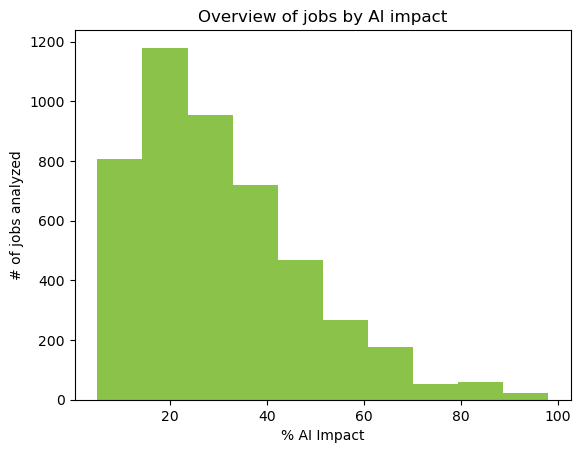

In [799]:
plt.hist(ai_risk["AI Impact"], bins=10, color = "#8bc34a")
plt.xlabel("% AI Impact")
plt.ylabel("# of jobs analyzed")
plt.title("Overview of jobs by AI impact")
plt.savefig("../pickles/AIrisk.jpg");

We can see that most occupations in this data set are at low-moderate risk from AI. We will have imbalanced classes and will need to stratify on our target variable for better results.

**Creating our risk categories**

With most of the feature variables categorical or text, and with a skew to the target variable, it will be more effective to run a multiclass classification model.

In [800]:
#Creating AI Impact categories
conditions = [
    (ai_risk["AI Impact"].astype(float) >= 75),
    (ai_risk["AI Impact"].astype(float) < 75) & (ai_risk["AI Impact"].astype(float) >= 50),
    (ai_risk["AI Impact"].astype(float) < 25),

]

choices = ["very high", "high", "low"]

In [801]:
ai_risk["rank"] = np.select(conditions, choices, "moderate")

In [802]:
ai_risk["rank"] = ai_risk["rank"].astype('category')

In [803]:
ai_risk["rank_new"] = ai_risk["rank"].cat.codes

In [804]:
dict_map = {0: 3, 3:4, 2:2, 1:1}
ai_risk["rank_new"] = ai_risk["rank_new"].map(dict_map)

In [805]:
ai_risk["rank"].value_counts()

low          1993
moderate     1909
high          674
very high     130
Name: rank, dtype: int64

In [806]:
ai_risk[ai_risk["rank"]=="very high"][["Job_title", "AI Impact", "rank", "rank_new"]].head(5)

,Job_title,AI Impact,rank,rank_new
0,Communications Manager,98.0,very high,4
1,Data Collector,95.0,very high,4
2,Data Entry,95.0,very high,4
3,Mail Clerk,95.0,very high,4
4,Compliance Officer,92.0,very high,4


We can see that job titles are repeating multiple times (i.e. Data Entry, Data Entry Clerk, Data Clerk, Data Entry Operator). However, even within this small range, it's possible to see that these titles differ in AI Impact - we will not have this level of granularity in our mapping (by industry and by occupation), and may, as a result, forego some prediction accuracy.

## EDA

Select all task rows, regardless of frequency of use.

In [807]:
tasks_importance = tasks[tasks["Scale Name"] == "Importance"]

### Job Titles in the O*NET datasets

We will need to preprocess the O*NET job titles in order to use them for mapping to the target variable dataset.

Occupations are plural (however removing 's' could remove occupations that are singular ending with 's', such as 'gas').

Occupations are delimited by ',', 'and', and ', and' (however, splitting by ',' or by 'and' could split occupations that are singular, such as "Training and development specialist").

Occupations have qualifiers that signal they are limited in scope, utilizing "except" as an indicator.

In [817]:
title_ref = tasks[tasks["Scale Name"] == "Importance"].groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [818]:
title_ref_ = pd.DataFrame(title_ref).reset_index()

In [819]:
title_ref_["Adj_title"] = title_ref_['Title'].agg(lambda x: ','.join(map(str, x)))

In [820]:
full_dataset_title = title_ref_["Adj_title"]

In [821]:
full_dataset_title_ = [re.split(r',|, and', x) for x in full_dataset_title]

In [822]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [823]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [824]:
for x in full_dataset_title_:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [825]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [826]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [827]:
exceptions = []
for x in full_dataset_title_:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

In [828]:
full_dataset_title_split = pd.DataFrame(full_dataset_title_, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [829]:
full_dataset_combined = full_dataset_title_split.merge(title_ref_.reset_index()[["Adj_title", "O*NET-SOC Code"]],
                                                          left_index = True, right_index = True, how="inner")

In [830]:
full_dataset_combined.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Adj_title           0
O*NET-SOC Code      0
dtype: int64

We have 234 (of 873) occupations that have a second 'component' to the job title. 173 with a third, 49 with a fourth.

We will consider stacking titles (creating additional data rows), and will need to make a decision on whether we match based on the first component of a title (Title1) or the full title (Adj_title) for higher accuracy.

### Mapping AI Risk to Occupation Data

We will use Fuzzy Match functions to map job titles across the two data sets. We will experiment with using:


*   Full Job Titles
*   Partial Job Titles
* A combination of both

We will use various fuzzy match techniques, to see which produces the highest % of matches.



In [831]:
full_dataset_combined["Match_Column"] = full_dataset_combined["Adj_title"]

In [832]:
full_dataset_combined.rename(columns={"Adj_title":"Title"},inplace=True)

In [833]:
full_dataset_combined["Match_Column"]= full_dataset_combined["Title"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))
#Full job title match

In [834]:
full_dataset_combined["Match_Column_unpacked"] = full_dataset_combined["Match_Column"].apply("|".join)

In [835]:
full_dataset_combined["Match_Ratio"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [836]:
full_dataset_combined["Match_Ratio_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [837]:
full_dataset_combined["Match_Column_1"]= full_dataset_combined["Title1"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x, ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))


In [838]:
full_dataset_combined["Match_Ratio_1"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_1, x.Title1), axis=1)

In [839]:
full_dataset_combined["Match_Ratio_1_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title1), axis=1)

In [840]:
full_dataset_combined["Match_Ratio_1b_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title), axis=1)

Partial Title Match Ratio has the highest average match, and the highest count of Titles with a match ratio >= 50%.


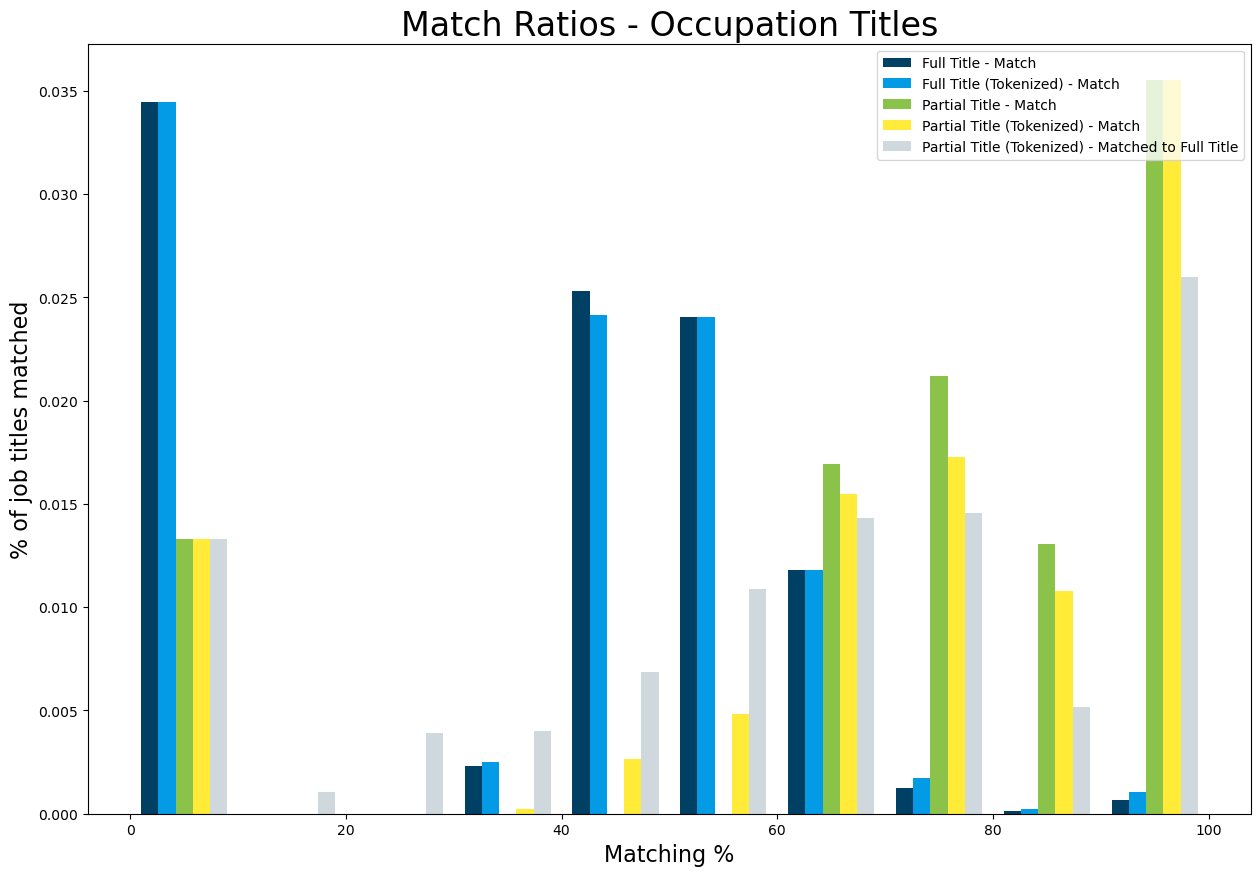

In [847]:
colorsb = ["#004065","#039be5","#8bc34a","#ffeb38", "#cfd8dc"]
x = full_dataset_combined[["Match_Ratio", "Match_Ratio_tokens", "Match_Ratio_1","Match_Ratio_1_tokens","Match_Ratio_1b_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar', color=colorsb)
plt.xlabel("Matching %" , fontsize=16)
plt.ylabel("% of job titles matched", fontsize=16)
plt.title('Match Ratios - Occupation Titles', fontsize=24)
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match","Partial Title - Match", "Partial Title (Tokenized) - Match", "Partial Title (Tokenized) - Matched to Full Title"], loc ="upper right", fontsize = '10')
plt.savefig("../Images/Title match.png");

## Feeding in the Target Values

In [848]:
def partial_match(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'AI Impact'].iloc[0]

In [849]:
def partial_match_(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'Job_title'].iloc[0]

In [850]:
full_dataset_combined["Match_Column_1"] = full_dataset_combined["Match_Column_1"].apply(lambda y: "" if y==[] else y)

In [852]:
full_dataset_combined_ = pd.merge(left=full_dataset_combined, right=ai_risk,
                                  left_on="Match_Column_1", right_on = "Job_title", how="left")

In [853]:
full_dataset_combined_.dropna(subset = ["AI Impact"], inplace=True)

In [854]:
full_dataset_combined_.rename(columns = {
    "AI Impact" : "aiimpact"
}, inplace = True)

In [855]:
full_dataset_combined_.to_pickle("../pickles/title_match.pkl")

In [856]:
full_dataset_combined_analysis = pd.merge(left=full_dataset_combined_, right=tasks_importance_task_crosstab,
                                          left_on=["O*NET-SOC Code"], right_on=["O*NET-SOC Code"], how = "left" )

Now we have a combined dataset, with tasks, matched titles and AI impact. Let's do some EDA.

First, we will do some quick lemmatizing on the text data (tasks and titles)

In [858]:
stops = nltk.corpus.stopwords.words('english')

In [859]:
def text_process(text):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [860]:
df_lemm_task = full_dataset_combined_analysis["Task"].apply(text_process)
df_lemm_title = full_dataset_combined_analysis["Title"].apply(text_process)

In [861]:
ytask = full_dataset_combined_analysis["rank_new"]

Because the tasks are mutually exclusive by Occupation, it's difficult to use them as a predictor.

What about, if we use the words in the tasks to indicate AI risk?

In [862]:
tasks_for_model = pd.DataFrame(df_lemm_task)

In [863]:
titles_for_model = pd.DataFrame(df_lemm_title)

In [864]:
y_lemm = pd.DataFrame(ytask)
y_lemm = y_lemm.reset_index(drop=True)

Let's visualize the most frequent 3-word combinations in Task and Title text, categorized by AI Risk.

In [865]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_task)
cvec_transform = cvec.transform(df_lemm_task)
tasks_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [866]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_title)
cvec_transformed = cvec.transform(df_lemm_title)
titles_lemmed = pd.DataFrame(cvec_transformed.todense(), columns=cvec.get_feature_names_out())

In [867]:
tasks_lemmed_ = pd.merge(tasks_lemmed, y_lemm, left_index=True, right_index=True)


In [868]:
titles_lemmed_ = pd.merge(titles_lemmed, y_lemm, left_index=True, right_index=True)

In [869]:
tasks_lemmed_["rank_new"].value_counts()

1.0    367
2.0    266
3.0    102
4.0     22
Name: rank_new, dtype: int64

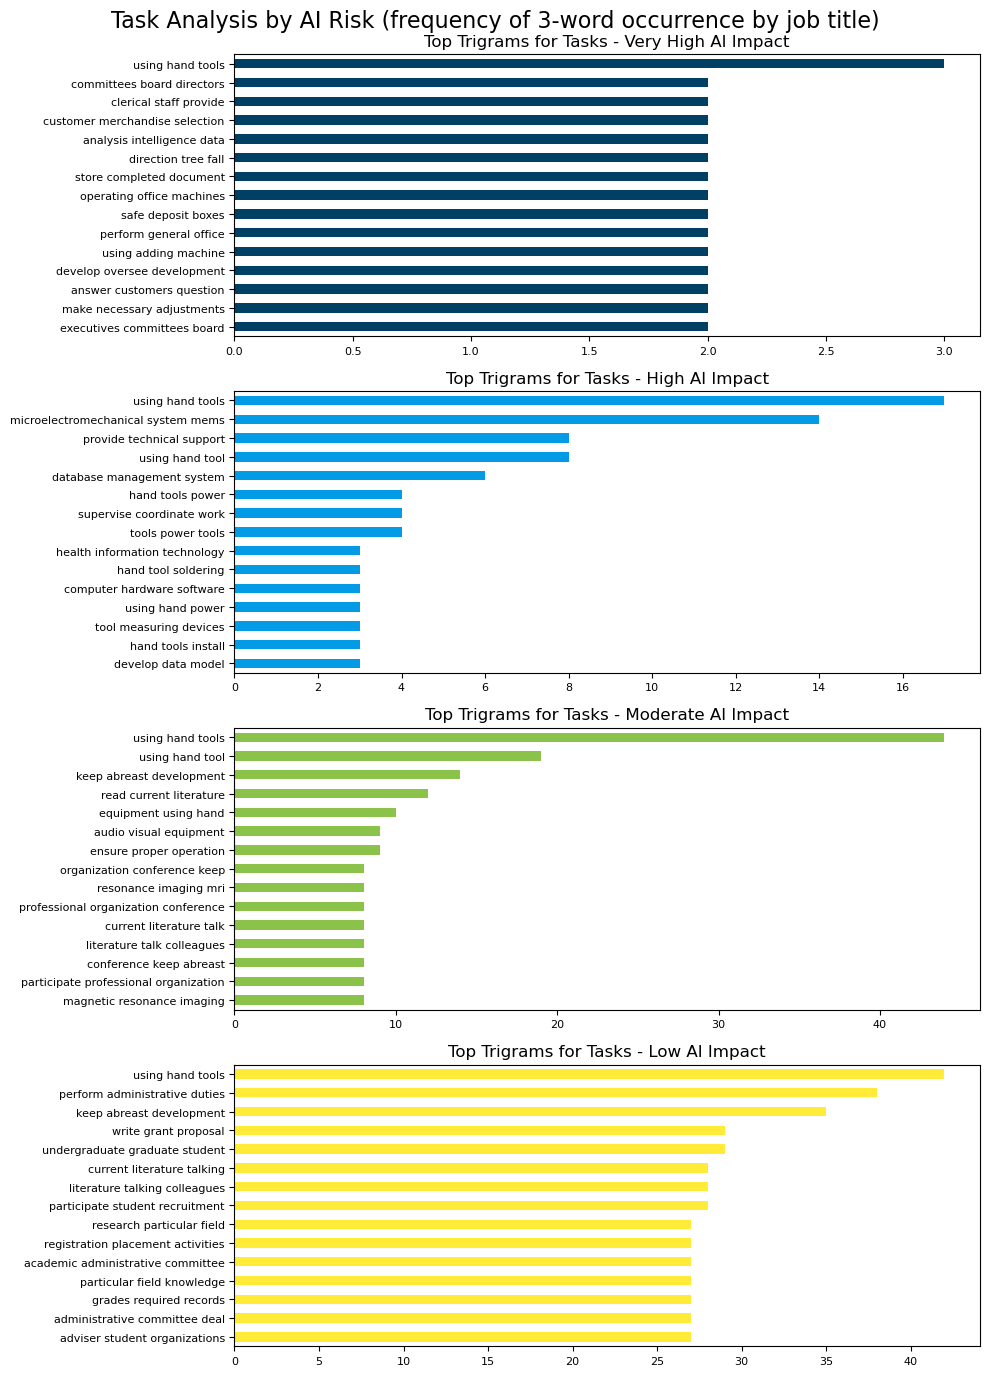

In [870]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14), tight_layout=True)

(tasks_lemmed_[tasks_lemmed_['rank_new'] == 4]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Very High AI Impact', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 3]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - High AI Impact', color='#039be5', fontsize=8, ax=axes[1])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Moderate AI Impact', color='#8bc34a', fontsize=8, ax=axes[2])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Low AI Impact', color='#ffeb38', fontsize=8, ax=axes[3])).invert_yaxis();


fig.suptitle('Task Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('../Images/Task Frequency by AI Risk.jpg');

We can see that there are tasks that appear frequently for occupations that are subject to Low or Moderate Impact from AI. For example, grant writing, facilitation, resonance imaging stand out as some of the examples. Interestingly, "using hand tools" appears across all 4 AI Impact categories, and could indicate the breadth of tools reflected across the occupations.

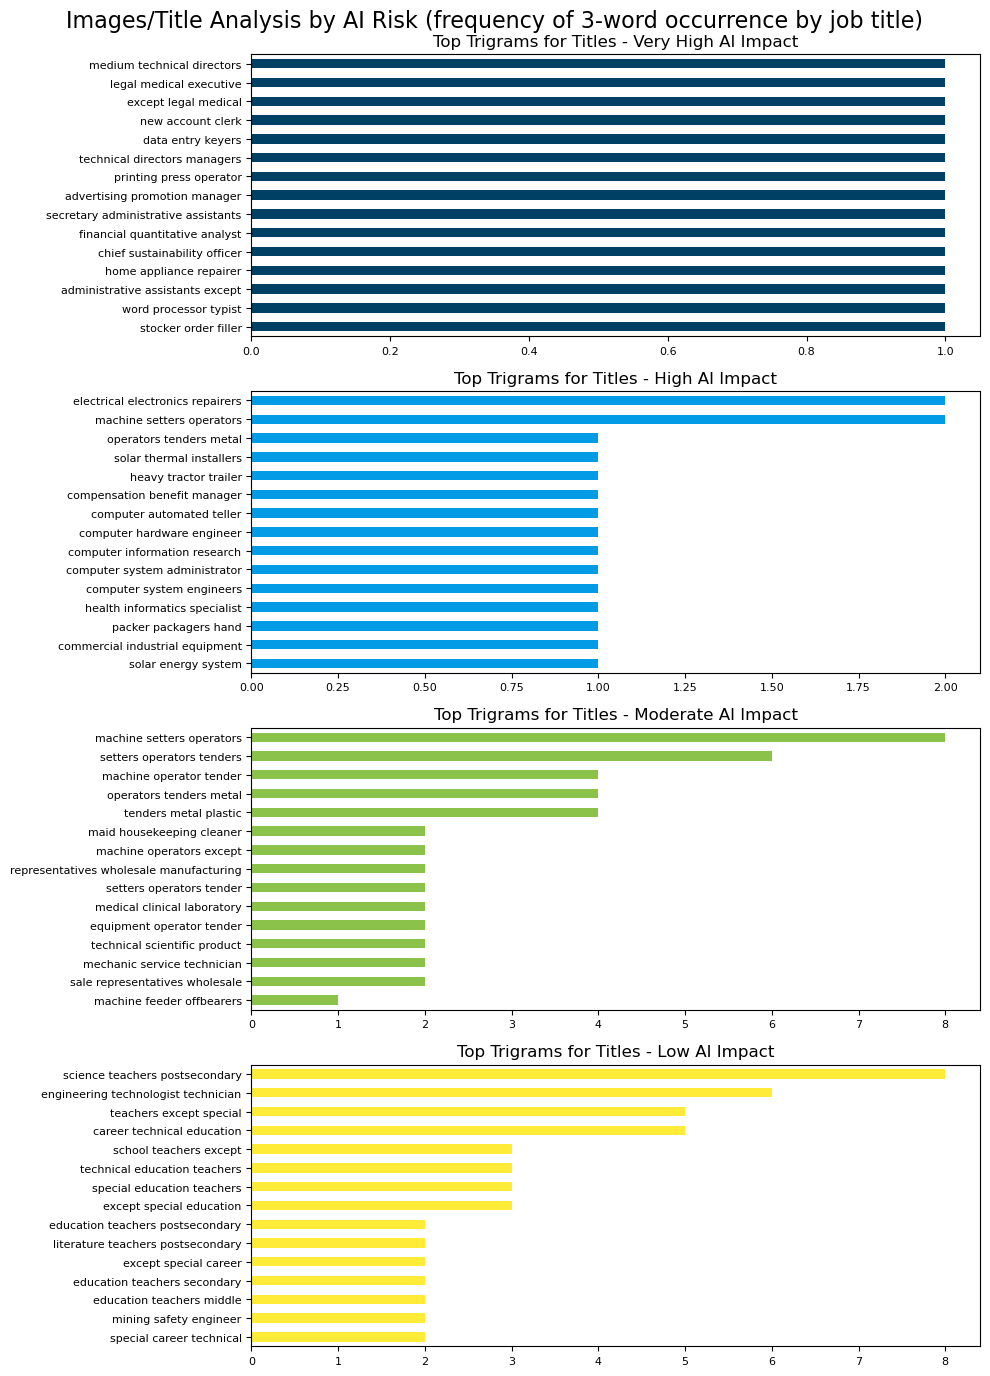

In [871]:
fig, axes = plt.subplots(4, 1, figsize=(10,14), tight_layout=True)

(titles_lemmed_[titles_lemmed_['rank_new'] == 4]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Very High AI Impact', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 3]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - High AI Impact', color='#039be5', fontsize=8, ax=axes[1])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Moderate AI Impact', color='#8bc34a', fontsize=8, ax=axes[2])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Low AI Impact', color='#ffeb38', fontsize=8, ax=axes[3])).invert_yaxis();


fig.suptitle('Images/Title Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('../Images/Title Frequency by AI Risk.jpg');

Interestingly, job titles reflect a similar trend as tasks, in that job titles of education professionals, medical specialists, and physical labor professionals are highly represented in the data set for occupations less impacted by AI.

## Analysis

In [470]:
def evaluation(name_of_the_model, y_test, preds, gs_model, X_train, X_test):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test, y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

In [562]:
ytask.value_counts(normalize=True)

1.0    0.484808
2.0    0.351387
3.0    0.134742
4.0    0.029062
Name: rank_new, dtype: float64

Our baseline is 48.5%. Our model will need to do better in order to add any meaningful value in predicting AI Impact.

We will run logistic regression on each component of the analysis separately, to see whether they help strengthen model performance relative to the baseline:
- Tasks (will complete NLP analysis)
- Titles (will complete NLP analysis)
- Industries (will complete both classification and NLP analysis)
- Skills (will complete )

#### Creating a task/title dataset

In [ ]:
## Number of Tasks
tasks_importance.shape[0]

17983

Drop columns not used in the analysis.

In [808]:
## Shorten the datasets for easier use
def drop_columns(x):
  x.drop(columns=['Title',
                  'Scale ID',
                  'Scale Name',
                  'Category',
                  'N',
                  'Standard Error',
                  'Lower CI Bound',
                  'Upper CI Bound',
                  'Recommend Suppress',
                  'Date',
                  'Domain Source'], inplace = True)


In [809]:
sources = [tasks_importance]
for source in sources:
  drop_columns(source)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/276582098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',


In [810]:
tasks_importance_task_crosstab = tasks_importance.groupby("O*NET-SOC Code")["Task"].apply(','.join).reset_index()

Combine by Task and Occupation



In [811]:
tasks_importance_crosstab = pd.crosstab(tasks_importance["O*NET-SOC Code"], tasks_importance["Task ID"],
                                            values=tasks_importance["Data Value"], aggfunc='mean').round(1)

In [812]:
tasks_importance_crosstab.reset_index(inplace=True)

This will be the Tasks dataset for further analysis.

### Task Analysis

In [872]:
Xtask_train, Xtask_test, y_train, y_test = train_test_split(df_lemm_task,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [873]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops]
}

In [874]:
pipe_cvec_logr_task = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver='liblinear'))
])

In [875]:
gs_task_cvec_logr = GridSearchCV(pipe_cvec_logr_task,
                pipe_params_cvec,
                  cv = 5)

In [876]:
gs_task_cvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [877]:
gs_task_cvec_logr_preds = gs_task_cvec_logr.predict(Xtask_test)

In [878]:
logistic_cvec_task = evaluation("Logistical Regression CVEC - Tasks", y_test, gs_task_cvec_logr_preds, gs_task_cvec_logr, Xtask_train, Xtask_test)

In [879]:
logistic_cvec_task

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tasks,0.764,0.484,0.552,0.598,0.5,0.525


Using language found in tasks doesn't help the model do much better than the baseline. I'll look at TFIDF just in case, but will be moving on to see if other features offer more meaningful contributions to the prediction strength of the model.

In [880]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [881]:
pipe_tvec_logr_task = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [882]:
gs_task_tvec_logr = GridSearchCV(pipe_tvec_logr_task,
                pipe_params_tvec,
                  cv = 5)

In [883]:
gs_task_tvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [884]:
gs_task_tvec_logr_preds = gs_task_tvec_logr.predict(Xtask_test)

In [885]:
logistic_tvec_task = evaluation("Logistical Regression TVEC - Tasks", y_test, gs_task_tvec_logr_preds, gs_task_tvec_logr, Xtask_train, Xtask_test)

In [886]:
logistic_tvec_task

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Tasks,0.79,0.495,0.701,0.511,0.511,0.591


There is some improvement on the baseline using TFIDF Logistic Regression, without any regularization. But the tasks alone aren't helping the model perform better than baseline.

### Title Analysis

Repeating the same analysis as above, but now for Titles as text.

In [887]:
Xtitle_train, Xtitle_test, y_train, y_test = train_test_split(df_lemm_title,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [888]:
pipe_cvec_logr_title = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [889]:
gs_title_cvec_logr = GridSearchCV(pipe_cvec_logr_title,
                pipe_params_cvec,
                  cv = 5)

In [890]:
gs_title_cvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [891]:
gs_title_cvec_logr_preds = gs_title_cvec_logr.predict(Xtitle_test)

In [892]:
logistic_cvec_title = evaluation("Logistical Regression CVEC - Title", y_test, gs_title_cvec_logr_preds, gs_title_cvec_logr, Xtitle_train, Xtitle_test)

In [893]:
logistic_cvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Title,0.716,0.542,0.552,0.717,0.587,0.569


This looks like an improvement on the baseline - and definitely something worth considering for predicting AI Impact.

In [894]:
pipe_tvec_logr_title = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [895]:
gs_title_tvec_logr = GridSearchCV(pipe_tvec_logr_title,
                pipe_params_tvec,
                  cv = 5)

In [896]:
gs_title_tvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [897]:
gs_title_tvec_logr_preds = gs_title_tvec_logr.predict(Xtitle_test)

In [898]:
logistic_tvec_title = evaluation("Logistical Regression TVEC - Title", y_test, gs_title_tvec_logr_preds, gs_title_tvec_logr, Xtitle_train, Xtitle_test)

In [899]:
logistic_tvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Title,0.61,0.516,0.537,0.663,0.537,0.537


While TFIDF produced less meaningful results than CVEC, text in job titles is useful to the model, and should be included.

### Tools Analysis

Let's look at tools and technology, and how it is related to AI Risk for a given job.


First, let's look at the tool usage by occupation and by tool.

In [902]:
tools_in_use = techskills.groupby("Tool")["Title"].agg(["count"]).sort_values(by="count", ascending=False)

In [903]:
titles_using_tools = techskills.groupby("Title")["Tool"].agg(["count"]).sort_values(by="count", ascending=False)

In [904]:
tools_crosstab = pd.crosstab(techskills["Title"], techskills["Tool"])

In [905]:
tools_crosstab_ = tools_crosstab.T

In [906]:
tools_in_use["pct"] = tools_in_use["count"]/len(tools_crosstab)
#determine what % of occupations use the tool

In [907]:
tools_in_use.describe()

,count,pct
count,8743.000000,8743.000000
mean,3.703992,0.004013
std,21.855634,0.023679
min,1.000000,0.001083
25%,1.000000,0.001083
50%,1.000000,0.001083
75%,2.000000,0.002167
max,855.000000,0.926327


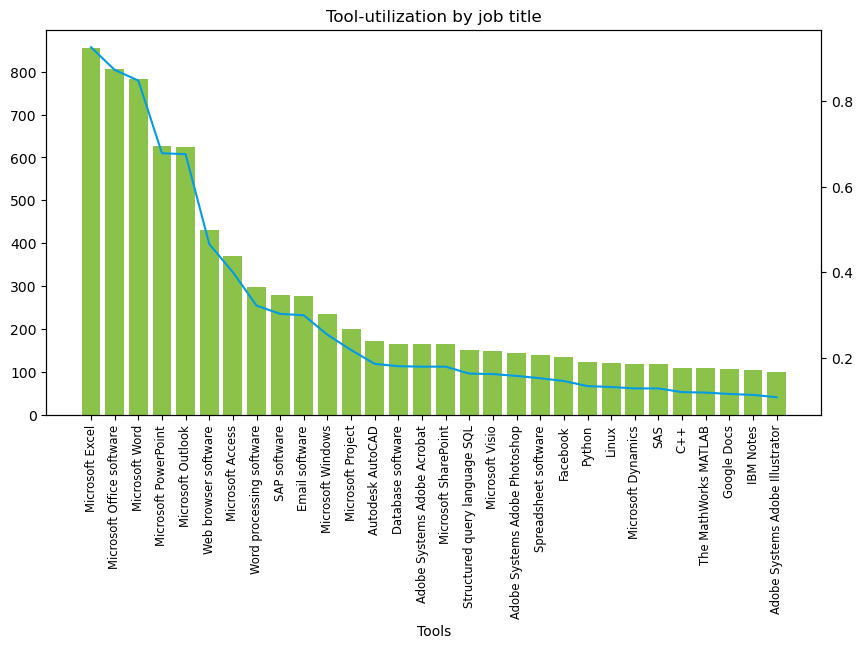

In [908]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["count"].head(30), color = '#8bc34a')
ax2.plot(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["pct"].head(30), color = '#039be5')

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Tools")
plt.title('Tool-utilization by job title')

plt.savefig('../Images/Tool Utilization.jpg');
#label rotation help from https://github.com/matplotlib/matplotlib/issues/7150

In [909]:
titles_crosstab = pd.crosstab(techskills["Tool"], techskills["Title"])

In [910]:
titles_crosstab_ = titles_crosstab.T

In [911]:
titles_using_tools["pct"] = titles_using_tools["count"]/len(titles_crosstab)

In [912]:
titles_using_tools.describe()

,count,pct
count,923.000000,923.000000
mean,35.085590,0.004013
std,46.033778,0.005265
min,1.000000,0.000114
25%,11.000000,0.001258
50%,21.000000,0.002402
75%,40.000000,0.004575
max,425.000000,0.048610


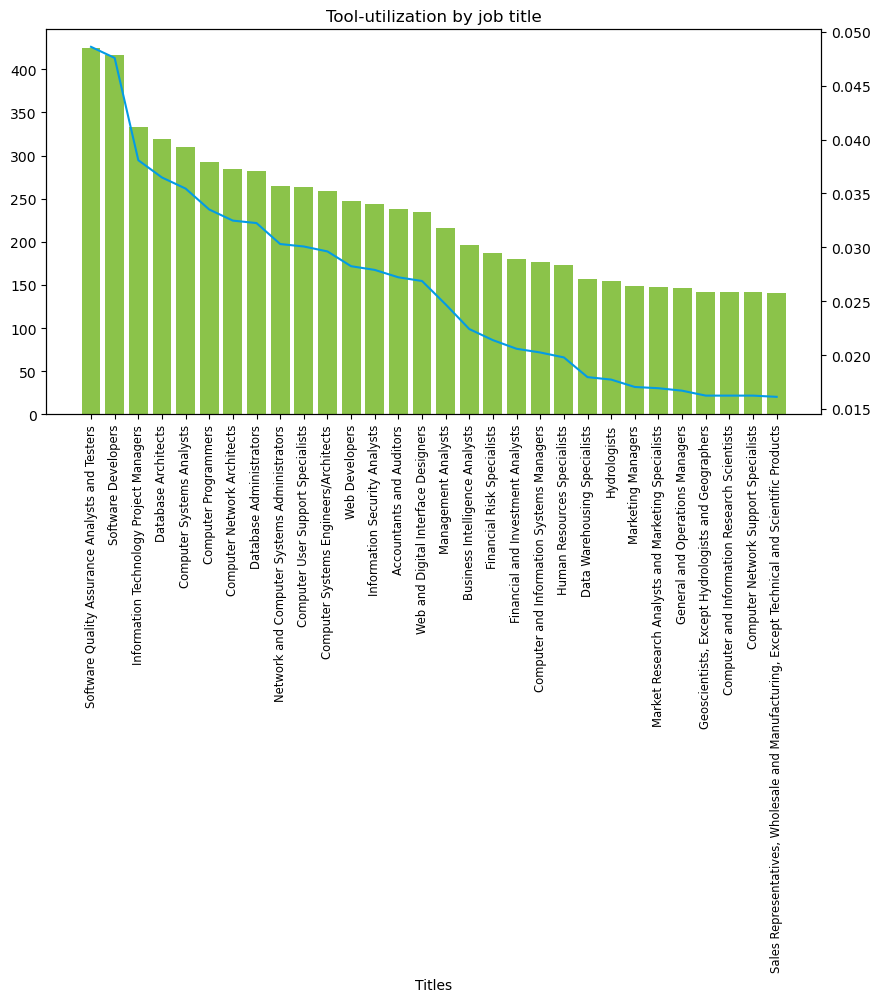

In [913]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["count"].head(30), color = '#8bc34a')
ax2.plot(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["pct"].head(30), color = '#039be5')

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Titles")
plt.title('Tool-utilization by job title')

plt.savefig('../Images/Tool Utilization by title.jpg');

There are 8743 distinct tools utilized across all 923 occupations included in the dataset.
The maximum number of different occupations per tool is 855; with an average of 3.7 occupations utilizing the same tool.
On average, an occupation utilizes 35 different tools, with a maximum of 425 tools per occupation.


With a lot of overlap between tools by occupation, the data will be filtered to include tools utilized by less than 60% of occupations.

In [1056]:
tools_to_include = tools_in_use.loc[tools_in_use['pct']< 0.60]

In [1057]:
column_list_tools = tools_to_include.index.tolist()

In [1058]:
tools_crosstab_filtered = tools_crosstab[column_list_tools]
#filter out tools which are used by 85% or more of occupations

In [1185]:
#ss = StandardScaler()
#tools_scaled = ss.fit_transform(tools_crosstab_filtered)

In [1199]:
#figuring out the optimal number of clusters
score = []

for k in range(10, 20):
    cl = KMeans(n_clusters=k, random_state=42, n_init=10)
    cl.fit(tools_crosstab_filtered)

    sil = silhouette_score(tools_crosstab_filtered, cl.labels_)


    score.append([k, cl.inertia_, sil])

score_df = pd.DataFrame(score, columns=['k', 'inertia', 'silhouette'])
score_df

,k,inertia,silhouette
0,10,21692.222044,-0.007952
1,11,21104.644828,0.119540
2,12,21382.147456,0.111273
3,13,20762.039720,0.063364
4,14,21001.017893,-0.141675
5,15,20569.904550,0.064192
6,16,20346.111957,0.111681
7,17,20182.443141,0.119737
8,18,20117.061367,0.030262
9,19,19956.204911,0.130756


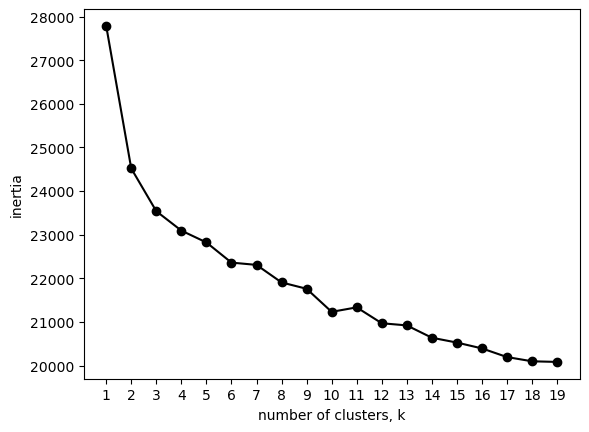

<Figure size 640x480 with 0 Axes>

In [1200]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(tools_crosstab_filtered)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('../Images/Km_tools.jpg');

In [1218]:
km_tools = KMeans(random_state=42, n_init=10, n_clusters=12)
km_tools.fit(tools_crosstab_filtered.drop(columns="cluster"))
#not using standard scaler here, because the data is binary (1, yes tool is used; 0, no it's not used)

KMeans(n_clusters=12, n_init=10, random_state=42)

In [1220]:
centroids = pd.DataFrame(
km_tools.cluster_centers_, columns = tools_crosstab_filtered.drop(columns="cluster").columns)

In [1221]:
joblib.dump(km_tools, '../pickles/Km_tools.pkl')

['../pickles/Km_tools.pkl']

It looks like the our jobs can be differentiated by tool use, using 15 clusters. This differentiation achieves the highest silhouette score.

In [1205]:
tools_crosstab_filtered["cluster"] = km_tools.labels_
#adding the cluster label to the tools table

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/3773043534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tools_crosstab_filtered["cluster"] = km_tools.labels_


We will also store the tool matrix with titles, so we can match titles by tool use in our app.

In [1206]:
pca_2 = PCA(2)
pca_2_result = pd.DataFrame(pca_2.fit_transform(tools_crosstab_filtered),columns=['PC1','PC2'])

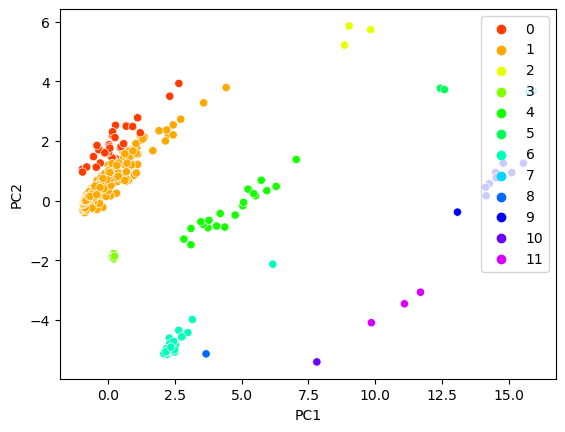

In [1207]:
pca_2_result['cluster'] = pd.Categorical(km_tools.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_result, palette="gist_rainbow")

plt.legend(loc='upper right')
plt.savefig('../Images/tool clusters.jpg');

Let's see what these clusters are:

In [1208]:
tools_crosstab_filtered["cluster"].value_counts()

1     801
6      38
0      34
4      20
3       9
9       9
2       3
11      3
5       2
7       2
10      1
8       1
Name: cluster, dtype: int64

In [1209]:
tools_clusters_grouped = tools_crosstab_filtered.reset_index().groupby("cluster")["Title"].apply(','.join).reset_index()

Tool clustering is very imbalanced, and looks like it won't provide significant differentiation.

### Skills Analysis

In [1096]:
skills_importance = skills[skills["Scale Name"] == "Importance"]

In [1097]:
skills_level = skills[skills["Scale Name"] == "Level"]

In [1098]:
skills_importance=skills_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"])
skills_level=skills_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"])

In [1100]:
skills_importance_crosstab = pd.crosstab(skills_importance["Title"], skills_importance["Element Name"],
                                values=skills_importance["Data Value"], aggfunc='mean').round(1)

In [1101]:
skills_importance_crosstab.reset_index(inplace=True)

In [1102]:
skills_level_crosstab = pd.crosstab(skills_level["Title"], skills_level["Element Name"],
                                values=skills_level["Data Value"], aggfunc='mean').round(1)

In [1103]:
skills_level_crosstab.reset_index(inplace=True)

In [1104]:
skills_list = ['Active Learning', 'Active Listening',
       'Complex Problem Solving', 'Coordination', 'Critical Thinking',
       'Equipment Maintenance', 'Equipment Selection', 'Installation',
       'Instructing', 'Judgment and Decision Making',
       'Learning Strategies', 'Management of Financial Resources',
       'Management of Material Resources',
       'Management of Personnel Resources', 'Mathematics', 'Monitoring',
       'Negotiation', 'Operation and Control', 'Operations Analysis',
       'Operations Monitoring', 'Persuasion', 'Programming',
       'Quality Control Analysis', 'Reading Comprehension', 'Repairing',
       'Science', 'Service Orientation', 'Social Perceptiveness',
       'Speaking', 'Systems Analysis', 'Systems Evaluation',
       'Technology Design', 'Time Management', 'Troubleshooting',
       'Writing']

In [1105]:
skills_merge = skills_importance_crosstab.merge(skills_level_crosstab, on=["Title"], suffixes = ["_importance", "_level"])

In [1106]:
w_list = []
z_list = []

for value in skills_list:

  w = "".join([value,"_importance"])
  z = "".join([value,"_level"])

  w_list.append(w)
  z_list.append(z)

  skills_merge[value] = skills_merge[w]*skills_merge[z]

In [1107]:
skills_filtered = skills_merge.drop(skills_merge.filter(regex ="_").columns, axis=1)
#keep only the interaction columns (where level * importance)

In [1108]:
skills_merge_copy = skills_filtered.copy().set_index("Title")

In [1109]:
skills_merge_copy.to_pickle("./skills.pkl")

In [1113]:
skills_mean = skills_merge_copy.describe().loc[['mean']]

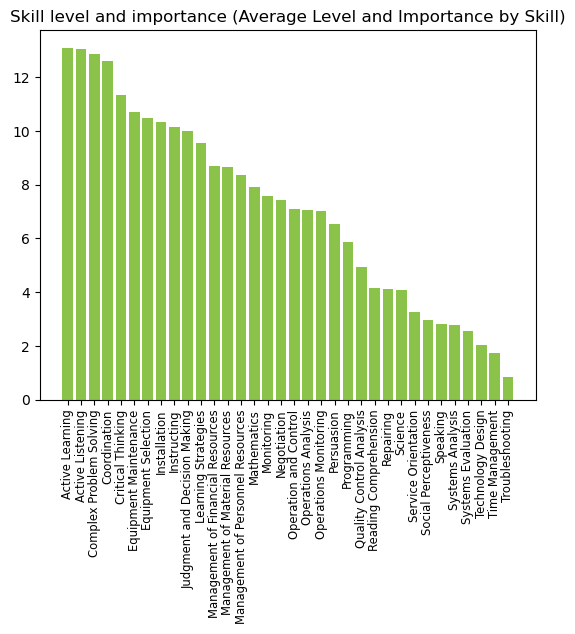

In [1371]:
plt.bar(skills_mean.iloc[: , :-1].columns, skills_mean.iloc[: , :-1].loc["mean"].sort_values(ascending=False), color = '#8bc34a')
plt.xticks(fontsize='small', rotation = 90)
plt.title("Skill level and importance (Average Level and Importance by Skill)")
plt.savefig("../Images/Skills.jpg");

In [1116]:
counts = [len(skills_merge_copy.T[skills_merge_copy.T[x]!=0.00]) for x in skills_merge_copy.T]

In [1117]:
skills_t = skills_merge_copy.T

In [1118]:
skills_index = skills_merge_copy.T.reset_index()

In [1119]:
skills_count = skills_t.append(pd.Series(counts, index = skills_t.columns),
           ignore_index=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/435882515.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skills_count = skills_t.append(pd.Series(counts, index = skills_t.columns),


In [1120]:
skills_count_ = pd.merge(left = skills_count, right = skills_index["Element Name"], left_index = True, right_index= True, how = "left" )

In [1121]:
skills_count_["Element Name"].fillna("count", inplace=True)

In [1122]:
skills_count_sorted = skills_count_.set_index("Element Name").T.sort_values(by="count", ascending=False).tail(30)

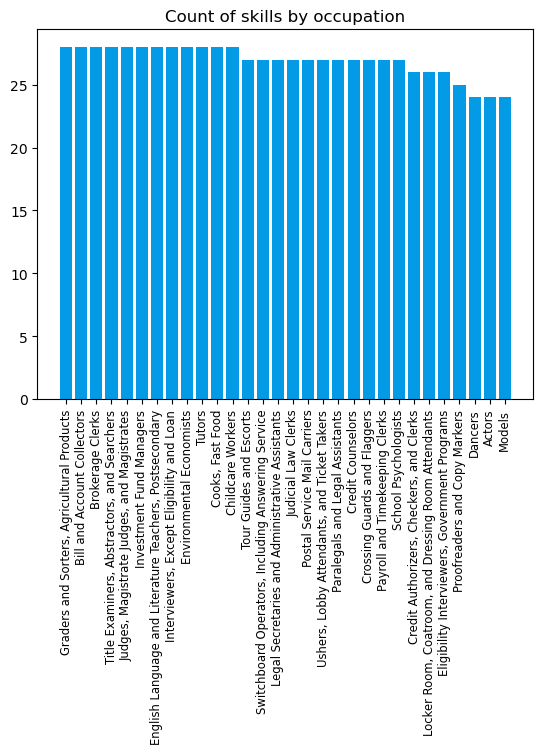

In [1123]:
plt.bar(skills_count_sorted.index, skills_count_sorted["count"], color = '#039be5')
plt.xticks(fontsize='small', rotation = 90)
plt.title("Count of skills by occupation")
plt.savefig("../Images/Skill count.jpg");

In [1124]:
skills_analysis = skills_count_.set_index("Element Name").T.reset_index()

In [1125]:
skills_analysis.rename(columns={"index": "Title"}, inplace=True)

In [1126]:
skills_rank = pd.merge(left = full_dataset_combined_[["Title", 'rank_new']], right = skills_analysis,
                             left_on = "Title", right_on = "Title", how="left")

In [1223]:
skills_analysis.columns

Index(['Title', 'Active Learning', 'Active Listening',
       'Complex Problem Solving', 'Coordination', 'Critical Thinking',
       'Equipment Maintenance', 'Equipment Selection', 'Installation',
       'Instructing', 'Judgment and Decision Making', 'Learning Strategies',
       'Management of Financial Resources', 'Management of Material Resources',
       'Management of Personnel Resources', 'Mathematics', 'Monitoring',
       'Negotiation', 'Operation and Control', 'Operations Analysis',
       'Operations Monitoring', 'Persuasion', 'Programming',
       'Quality Control Analysis', 'Reading Comprehension', 'Repairing',
       'Science', 'Service Orientation', 'Social Perceptiveness', 'Speaking',
       'Systems Analysis', 'Systems Evaluation', 'Technology Design',
       'Time Management', 'Troubleshooting', 'Writing', 'count', 'cluster'],
      dtype='object', name='Element Name')

In [1224]:
ss = StandardScaler()
skills_scaled = ss.fit_transform(skills_analysis.drop(columns=["Title", "count","cluster"]))

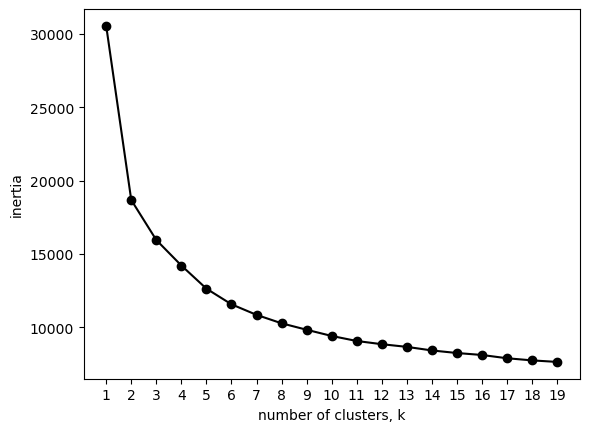

<Figure size 640x480 with 0 Axes>

In [1132]:
#Let's see clustering by skill
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(skills_scaled)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('../Images/Km_skills.jpg');

In [1225]:
km_skills = KMeans(random_state=42, n_init=10, n_clusters=7)
km_skills.fit(skills_scaled)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [1227]:
centroids_skills = pd.DataFrame(
km_skills.cluster_centers_, columns = skills_analysis.drop(columns=["Title","count","cluster"]).columns)

In [1141]:
joblib.dump(km_skills, '../pickles/Km_skills.pkl')

['../pickles/Km_skills.pkl']

In [1142]:
skills_analysis["cluster"] = km_skills.labels_

In [1229]:
skills_grouped = skills_analysis.reset_index().groupby("cluster")["Title"].apply(','.join).reset_index()

In [1230]:
skills_grouped_for_sl = pd.merge(left=skills_analysis, right = skills_rank[["Title", "rank_new"]],
                                 left_on="Title", right_on = "Title", how="left")

In [1231]:
joblib.dump(skills_grouped_for_sl, '../pickles/skills_f.pkl')

['../pickles/skills_f.pkl']

In [1155]:
pca_2_skills = PCA(2)
pca_2_skills_result = pd.DataFrame(pca_2_skills.fit_transform(skills_scaled),columns=['PC1','PC2'])

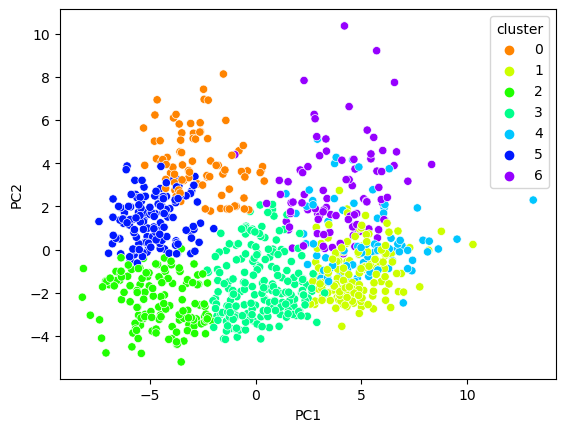

In [1156]:
pca_2_skills_result['cluster'] = pd.Categorical(km_skills.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_skills_result,palette="gist_rainbow")
plt.savefig('../Images/skill clusters.jpg');

While 7 clusters seem to be sufficient to differentiate between occupations by skill, there's some overlap between clusters 2, 4 and 7.

In [1211]:
skills_imputer = skills_grouped_for_sl.drop(columns=["Title", "rank_new", "cluster", "count"])

In [1212]:
ss = StandardScaler()
skills_imputer_ = ss.fit_transform(skills_imputer)

In [1216]:
imputer = KNNImputer(n_neighbors=7)
imputedX = imputer.fit_transform(skills_imputer_)
joblib.dump(imputer, '../pickles/imputer.pkl')

['../pickles/imputer.pkl']

In [1166]:
skills_grouped_for_sl.dropna(inplace=True)

In [1167]:
Xskills = skills_grouped_for_sl.drop(columns = ["cluster", "count","Title", "rank_new"])

In [1168]:
yskills = skills_grouped_for_sl["rank_new"]

In [1169]:
X_skills_train, X_skills_test, y_train, y_test = train_test_split(Xskills,
                                                    yskills,
                                                    random_state=42, stratify=yskills)

In [1170]:
sc = StandardScaler()
X_skills_train = sc.fit_transform(X_skills_train)
X_skills_test = sc.transform(X_skills_test)

In [1171]:
logr_skills = LogisticRegression(multi_class="multinomial")

In [1179]:
pipe_params_logr_skills = {
    'C': [0.01, 1.0, 10, 100],
    'penalty': ['l2'],
    'max_iter': [5000]}
    #'mnb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],

In [1180]:
gs_skills_logr = GridSearchCV(logr_skills,
                                  pipe_params_logr_cvec,
                                  cv=5)

In [1181]:
gs_skills_logr.fit(X_skills_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 1.0, 10, 100], 'max_iter': [5000],
                         'penalty': ['l2']})

In [1182]:
gs_skills_logr_preds = gs_skills_logr.predict(X_skills_test)

In [1301]:
logistic_skills = evaluation("Logistical Regression - Skills", y_test, gs_skills_cvec_logr_preds, gs_skills_cvec_logr,
                                X_skills_train, X_skills_test)

In [1302]:
logistic_skills

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Skills,0.578,0.605,0.508,0.833,0.681,0.582


Looking at Skills, there was an improvement to the prediction of the model when scaling the data and analyzing magnitudes of level and importance for each skill by occupation.

### Industry Analysis

Let's look at whether Industry information (either NLP or binary) will be helpful in predicting AI Impact

In [938]:
industries["Industries_adjusted"] = industries["Industries"].str.replace(r'(\(.*?\))',"", regex=True)

In [939]:
industries.rename(columns = {"Occupation":"Title"}, inplace=True)

In [940]:
industries_copy = industries.copy()

In [941]:
exp_cols = industries["Industries"].str.split(r'(\(.*?\))', expand=True)
industries_copy = pd.merge(industries, exp_cols, left_index=True, right_index=True, how="left")

In [942]:
industries_copy.columns = ["Code",
                      "Title",	"Projected Growth (2022-2032)",
                      "Projected Job Openings (2022-2032)",
                      "Industries",
                      "Industries_adjusted",
                      "Split_0", "Split_1",
                      "Split_2",	"Split_3",	"Split_4",	"Split_5",
                      "Split_6",	"Split_7",	"Split_8",	"Split_9",	"Split_10",
                      "Split_11","Split_12","Split_13","Split_14"]

In [943]:
#removing %s from Industry values
industries_copy["Split_0"].replace(r'(\(.*?\)), ',"", regex=True, inplace=True)
industries_copy.replace(r'(\(.*?\))',"", regex=True, inplace=True)

We will categorize our industries for further analysis

In [944]:
enci = OneHotEncoder(sparse_output=False)

In [945]:
ohedata = pd.DataFrame(enci.fit_transform(industries_copy[["Split_0"]]), columns=enci.categories_).reset_index()

In [946]:
industries_copy = pd.merge(left=industries_copy, right=ohedata, left_index=True, right_index=True, how="left")

In [947]:
industries_copy.columns = ['Code', 'Title','Projected Growth (2022-2032)',
                         'Projected Job Openings (2022-2032)',   'Industries',  'Industries_adjusted', 'Split_0',
                                                    'Split_1', 'Split_2', 'Split_3',  'Split_4',
                                                    'Split_5',  'Split_6', 'Split_7',
                                                    'Split_8',  'Split_9',  'Split_10',  'Split_11',
                                                   'Split_12', 'Split_13',  'Split_14',  'index',
                            'Accommodation and Food Services',  'Administrative and Support Services',
                'Agriculture, Forestry, Fishing, and Hunting',  'Arts, Entertainment, and Recreation',
                                               'Construction',  'Educational Services',  'Finance and Insurance',    'Government',
                          'Health Care and Social Assistance',   'Information ', 'Management of Companies and Enterprises',
                                              'Manufacturing',   'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services',   'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing', 'Retail Trade',
                             'Transportation and Warehousing', 'Utilities',  'Wholesale Trade']

In [948]:
industry_analysis = pd.merge(left=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], right=industries_copy, left_on="O*NET-SOC Code", right_on="Code", how="left")

In [949]:
X_industry = industry_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [950]:
joblib.dump(X_industry.columns, '../pickles/industry_cols.pkl')

['../pickles/industry_cols.pkl']

In [951]:
X_industry_ = industry_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade', "rank_new", "Title", 'Projected Growth (2022-2032)',
                         'Projected Job Openings (2022-2032)']]

In [952]:
X_industry.fillna(0, inplace=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/2098419266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_industry.fillna(0, inplace=True)


In [953]:
y_industry = industry_analysis["rank_new"]

In [954]:
score = []

for k in range(2,15):
    cl = KMeans(n_clusters=k, random_state=42, n_init=10)
    cl.fit(X_industry)

    sil = silhouette_score(X_industry, cl.labels_)


    score.append([k, cl.inertia_, sil])

score_df = pd.DataFrame(score, columns=['k', 'inertia', 'silhouette'])
score_df

,k,inertia,silhouette
0,2,574.657895,0.236904
1,3,471.814607,0.372770
2,4,399.790672,0.467239
3,5,339.789340,0.547207
4,6,239.147170,0.680108
5,7,249.240132,0.666882
6,8,178.865672,0.759762
7,9,147.604790,0.801070
8,10,127.972789,0.827026
9,11,105.626016,0.856568


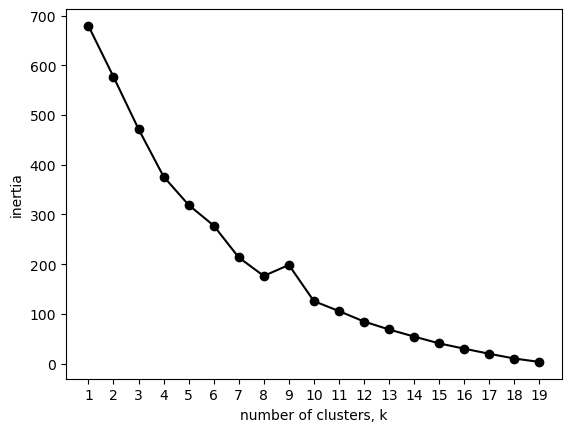

<Figure size 640x480 with 0 Axes>

In [955]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(X_industry)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('../Images/Km_industries.jpg');

In [956]:
km_industries = KMeans(random_state=42, n_init=10, n_clusters=10)
km_industries.fit(X_industry)
#not using standard scaler here, because the data is binary (1, yes tool is used; 0, no it's not used)

KMeans(n_clusters=10, n_init=10, random_state=42)

Let's consider 10 clusters to differentiate titles by industry.

In [957]:
centroids = pd.DataFrame(
km_industries.cluster_centers_, columns = X_industry.columns)

In [958]:
joblib.dump(km_industries, '../pickles/Km_industries.pkl')

['../pickles/Km_industries.pkl']

In [959]:
X_industry.loc[:,"cluster"] = km_industries.labels_
#adding the cluster label to the tools table

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/2411078086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_industry.loc[:,"cluster"] = km_industries.labels_


In [960]:
X_industry_.loc[:,"cluster"] = km_industries.labels_

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/1904917864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_industry_.loc[:,"cluster"] = km_industries.labels_


In [961]:
joblib.dump(X_industry_, '../pickles/industry_.pkl')

['../pickles/industry_.pkl']

We will also store the tool matrix with titles, so we can match titles by tool use in our app.

In [962]:
full_dataset_combined_.reset_index(inplace = True)

In [963]:
pca_2 = PCA(2)
pca_2_industry = pd.DataFrame(pca_2.fit_transform(X_industry),columns=['PC1','PC2'])

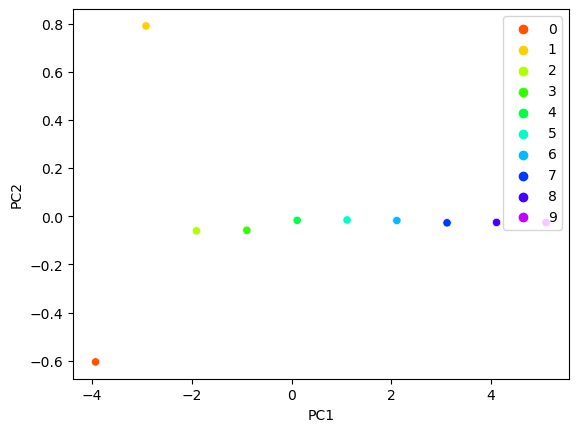

In [964]:
pca_2_industry['cluster'] = pd.Categorical(km_industries.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_industry, palette="gist_rainbow")

plt.legend(loc='upper right')
plt.savefig('../Images/industry clusters.jpg');

#### Binary Industry Analysis (dominant industry only)

In [965]:
Xind_train, Xind_test, y_train, y_test = train_test_split(X_industry,
                                                    y_industry,
                                                    random_state=42, stratify=y_industry)

In [971]:
logr_industry = LogisticRegression(max_iter = 1000)

In [972]:
logr_industry.fit(Xind_train, y_train)

LogisticRegression(max_iter=1000)

In [973]:
gs_ind_logr_preds = logr_industry.predict(Xind_test)

In [974]:
logistic_industry = evaluation("Logistical Regression - Industry", y_test, gs_ind_logr_preds, logr_industry,
                                Xind_train, Xind_test)

In [975]:
logistic_industry

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Industry,0.543,0.521,0.463,0.739,0.564,0.509


Industry has some impact on the model's ability to predict AI Impact. However, we only looked at the dominant industry for an occupation. What if we look at all industries associated with an occupation?

In [1019]:
industries_grouped = industry_analysis.groupby(["rank_new"])[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']].agg(['sum'])

In [1021]:
industries_grouped.columns = ['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']

In [1022]:
industry_transposed = industries_grouped.T

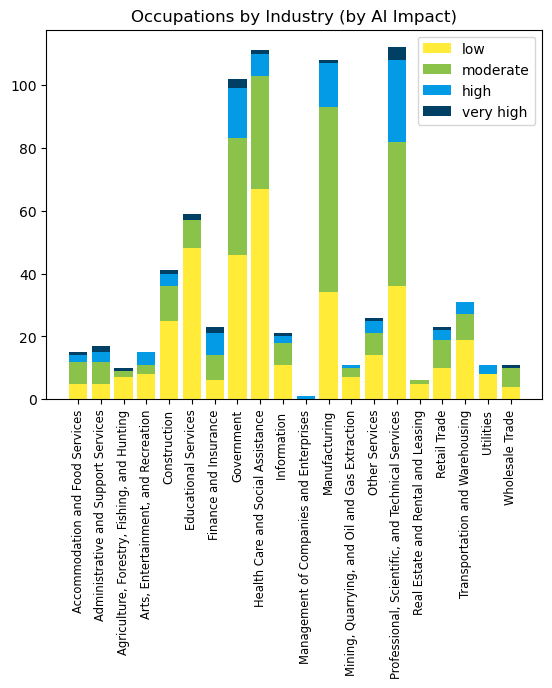

In [1025]:
fig, ax = plt.subplots()

colors = ['#ffeb38','#8bc34a', "#039be5", "#004065"]
bottom = np.zeros(len(industry_transposed))

for i, col in enumerate(industry_transposed.columns):
  ax.bar(industry_transposed.index, industry_transposed[col], bottom=bottom, label=col, color = colors[i])
  bottom += np.array(industry_transposed[col])
  ax.tick_params(axis='x', labelsize='small', rotation=90)

ax.set_title('Occupations by Industry (by AI Impact)')
ax.legend(["low", "moderate", "high", "very high"])
plt.savefig("../Images/Occupations by Industry.jpg");

#### Binary Industry Analysis (all industries per occupation)

In [1026]:
industries_copy_2 = industries.copy()

In [1027]:
s=pd.DataFrame([[x] + [z] for x, y in zip(industries_copy_2.index,industries_copy_2.Industries.str.split(r'(\(.*?\))')) for z in y],
               columns=[0,'Industry'])
industries_split =s.merge(industries_copy_2,left_on=0,right_index=True).drop(0,1)
#https://stackoverflow.com/questions/55981347/how-to-split-and-duplicate-rows-according-to-string-in-one-column-with-python

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/3317364567.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  industries_split =s.merge(industries_copy_2,left_on=0,right_index=True).drop(0,1)


In [1028]:
industries_split["Industry"].replace(r'(\(.*?\))',"", regex=True, inplace=True)

In [1029]:
industries_split_filtered = industries_split[industries_split['Industry'] != ""]
#remove blank rows

In [1030]:
def trimfunc(str):
    if str[:2] == ', ':
        return str.lstrip(', ')
    else:
        return str
#help from Sonyah to remove leading commas

In [1031]:
industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_44986/3133922866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))


In [1032]:
enci = OneHotEncoder(sparse_output=False)

In [1033]:
ohedata_ = pd.DataFrame(enci.fit_transform(industries_split_filtered[["Industry"]]),
                       columns=enci.categories_).reset_index()

In [1034]:
industries_ = pd.merge(left=industries_split_filtered, right=ohedata_, left_index=True, right_index=True, how="left")

In [1035]:
industries_analysis_ = pd.merge(left=industries_,
                             right=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], left_on="Code", right_on="O*NET-SOC Code", how="left")

In [1036]:
industries_analysis_.dropna(inplace=True)
#unmatched rank columns

In [1037]:
industries_analysis_.columns = ["Industry", 'Code','Title','Projected Growth (2022-2032)',
                         'Projected Job Openings (2022-2032)','Industries','Industries_adjusted',
                                                      'index',"", 'Accommodation and Food Services',
                        'Administrative and Support Services','Agriculture, Forestry, Fishing, and Hunting',
                        'Arts, Entertainment, and Recreation', 'Construction',
                                       'Educational Services', 'Finance and Insurance',
                                                 'Government','Health Care and Social Assistance',
                                               'Information ', 'Management of Companies and Enterprises',
                                              'Manufacturing', 'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services', 'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing', 'Retail Trade','Transportation and Warehousing',  'Utilities',
                                            'Wholesale Trade',"O*NET-SOC Code", "rank_new"]

In [1038]:
Xinds = industries_analysis_[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [1039]:
yinds = industries_analysis_['rank_new']

In [1040]:
Xinds_train, Xinds_test, y_train, y_test = train_test_split(Xinds,
                                                    yinds,
                                                    random_state=42, stratify=yinds)

In [1041]:
logr_industries = LogisticRegression()

In [1042]:
logr_industries.fit(Xinds_train, y_train)

LogisticRegression()

In [1043]:
gs_indi_logr_preds = logr_industries.predict(Xinds_test)

In [1044]:
logistic_industries = evaluation("Logistical Regression - Industries", y_test, gs_indi_logr_preds, logr_industries,
                                Xinds_train, Xinds_test)

In [1045]:
logistic_industries

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Industries,0.479,0.431,0.556,0.621,0.577,0.566


This model does worse than the original single-industry analysis, indicating that industries aren't indicative of AI risk for an occupation. We will keep just the dominant industry for our analysis.

#### NLP Industry Analysis

Final look at how industries help predict AI Impact.

In [1046]:
industries_nlp = pd.merge(left=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], right=industries[["Code", "Industries_adjusted"]],
                          left_on="O*NET-SOC Code", right_on="Code", how="left")

In [1047]:
df_lemm_industry_ = industries_nlp[["Industries_adjusted","rank_new"]].sort_values(by="Industries_adjusted")[:-3]

In [1048]:
df_lemm_industry = df_lemm_industry_["Industries_adjusted"].apply(text_process)

In [1049]:
Xindnlp_train, Xindnlp_test, y_train, y_test = train_test_split(df_lemm_industry,
                                                    df_lemm_industry_["rank_new"],
                                                    random_state=42, stratify=df_lemm_industry_["rank_new"])

In [1050]:
pipe_cvec_logr_industry = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [1051]:
gs_industry_cvec_logr = GridSearchCV(pipe_cvec_logr_industry,
                pipe_params_cvec,
                  cv = 5)

In [1052]:
gs_industry_cvec_logr.fit(Xindnlp_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [1053]:
gs_industry_cvec_logr_preds = gs_industry_cvec_logr.predict(Xindnlp_test)

In [1054]:
logistic_cvec_industry = evaluation("Logistical Regression CVEC - Industry", y_test, gs_industry_cvec_logr_preds, gs_industry_cvec_logr, Xindnlp_train, Xindnlp_test)

In [1055]:
logistic_cvec_industry

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Industry,0.524,0.328,0.162,0.733,0.273,0.203


Industry language doesn't help predict AI Impact. We'll stick to including the dominant industry only.

Now, we'll see if tools help us predict AI Risk.

In [1234]:
tech_merge_ = pd.merge(left = tools_crosstab_filtered, right = full_dataset_combined_[["Title", 'rank_new']],
                             left_on = "Title", right_on = "Title", how="left")

In [1235]:
joblib.dump(tech_merge_, '../pickles/tools_.pkl')

['../pickles/tools_.pkl']

In [1236]:
tech_merge = pd.merge(left = full_dataset_combined_[["Title", 'rank_new']], right = tools_crosstab_filtered,
                             left_on = "Title", right_on = "Title", how="left")

In [1237]:
X_tools = tech_merge.drop(columns=["cluster", "rank_new"])

In [1238]:
pd.set_option('display.max_rows', None)

In [1239]:
y_tools = tech_merge["rank_new"]

### Using Tools as Binary Indicators in the model

### Tool utilization by occupation

We'll move forward with creating a table, where tools are grouped by occupation, to see how 'tool combinations' are related to AI Risk.
This is intended to showcase how a composite of tools in a single occupation can make an occupation more or less susceptible to AI replacement.

In [1240]:
tech_df =techskills.groupby("O*NET-SOC Code")["Tool"].apply(np.unique).reset_index()

In [1241]:
tech_df_ = pd.merge(left = tech_df, right =full_dataset_combined_,
                             left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [1242]:
tech_df_filtered = tech_df_[tech_df_['rank_new'].notna()]

In [1243]:
df_lemm_tool = tech_df_filtered["Tool"].apply(', '.join)

Tools grouped for NLP analysis

In [1244]:
tools_lemmed_ = pd.merge(left=df_lemm_tool, right=tech_df_filtered[["Title","rank_new"]],
                         left_index=True, right_index=True, how="left")

Tools grouped for Binary analysis

In [1245]:
tools_count = pd.merge(left = techskills, right = tech_df_filtered,
                       left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [1246]:
#Low AI Risk
tools_count_low = tools_count[tools_count["rank_new"]==1.0]
tools_count_low_ = tools_count_low.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_low__ = tools_count_low_["Tool_y"].set_index(tools_count_low_["Tool_x"]).reset_index()
tools_count_low__["pct"] = tools_count_low__["count"]/len(tools_count_low__)
tools_count_low__["pct"] = tools_count_low__["pct"].apply('{:.00%}'.format)
tools_count_low__ = tools_count_low__.sort_values(by=["pct"], ascending=False)

In [1247]:
tools_count_med = tools_count[tools_count["rank_new"]==2.0]
tools_count_med_ = tools_count_med.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_med__ = tools_count_med_["Tool_y"].set_index(tools_count_med_["Tool_x"]).reset_index()
tools_count_med__["pct"] = tools_count_med__["count"]/len(tools_count_med__)
tools_count_med__["pct"] = tools_count_med__["pct"].apply('{:.00%}'.format)
tools_count_med__ = tools_count_med__.sort_values(by=["pct"], ascending=False)

In [1248]:
tools_count_high = tools_count[tools_count["rank_new"]==3.0]
tools_count_high_ = tools_count_high.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_high__ = tools_count_high_["Tool_y"].set_index(tools_count_high_["Tool_x"]).reset_index()
tools_count_high__["pct"] = tools_count_high__["count"]/len(tools_count_high__)
tools_count_high__["pct"] = tools_count_high__["pct"].apply('{:.00%}'.format)
tools_count_high__ = tools_count_high__.sort_values(by=["pct"], ascending=False)

In [1249]:
tools_count_vhigh = tools_count[tools_count["rank_new"]==4.0]
tools_count_vhigh_ = tools_count_vhigh.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_vhigh__ = tools_count_vhigh_["Tool_y"].set_index(tools_count_vhigh_["Tool_x"]).reset_index()
tools_count_vhigh__["pct"] = tools_count_vhigh__["count"]/len(tools_count_vhigh__)
tools_count_vhigh__["pct"] = tools_count_vhigh__["pct"].apply('{:.00%}'.format)
tools_count_vhigh__ = tools_count_vhigh__.sort_values(by=["pct"], ascending=False)

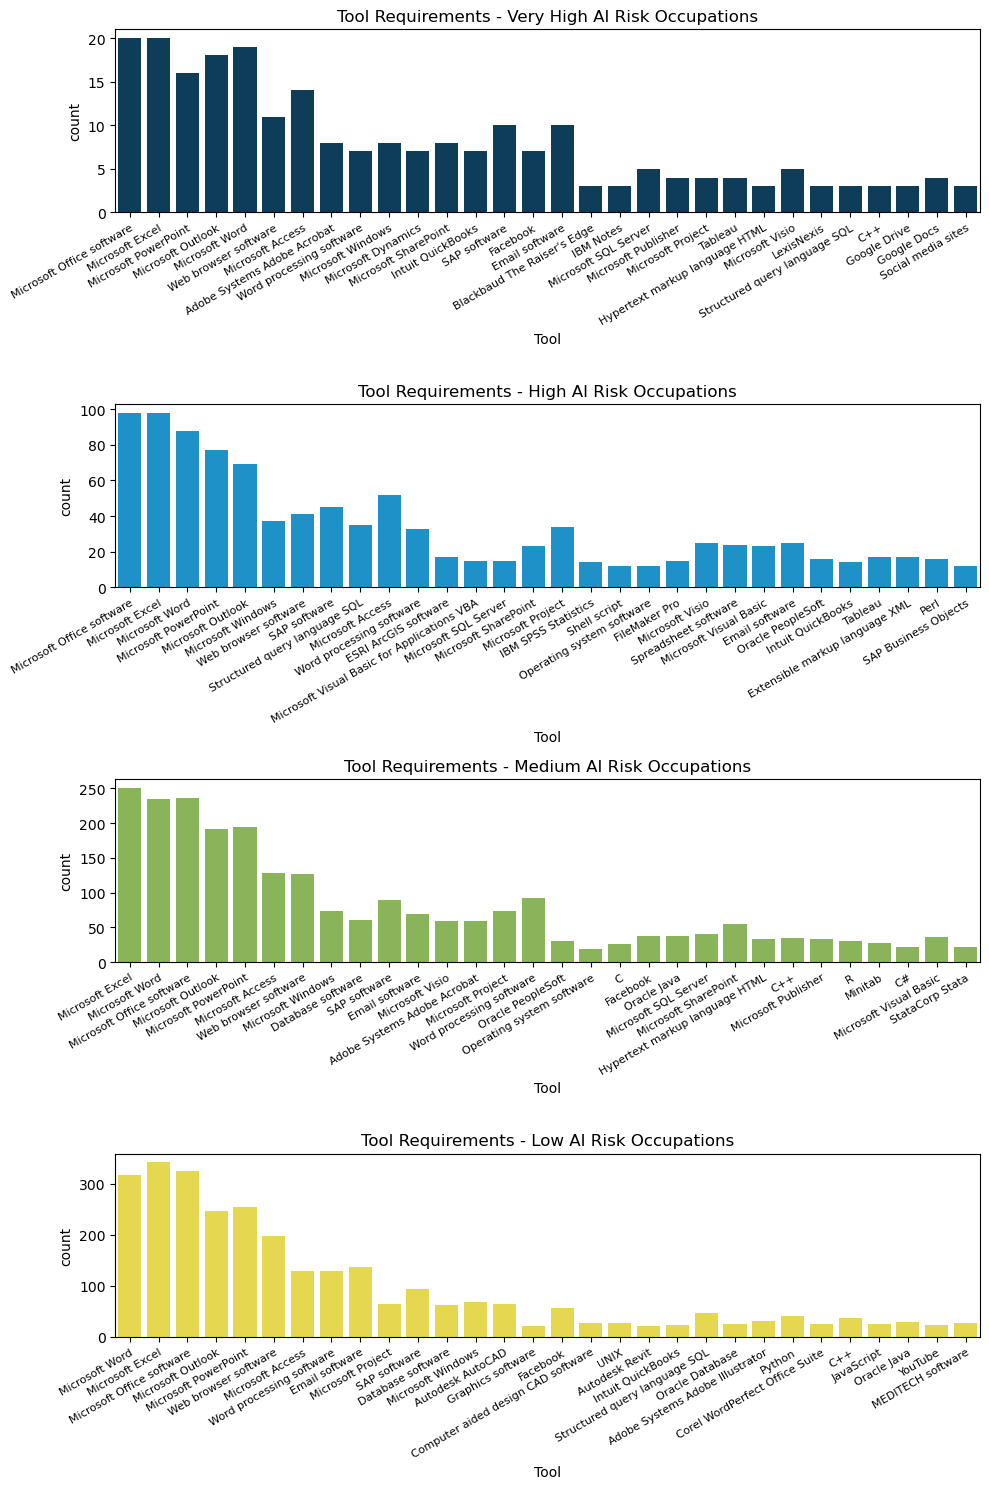

In [1250]:
fig, axes = plt.subplots(4, 1, figsize=(10, 15), tight_layout=True, sharex=False, sharey=False)

ax1 = sns.barplot(x=tools_count_low__["Tool_x"].head(30), y=tools_count_low__["count"].head(30),
            color='#ffeb38', ax=axes[3]).set(title='Tool Requirements - Low AI Risk Occupations')
axes[3].set_xticklabels(tools_count_low__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[3].set_xlabel('Tool')
ax2 = sns.barplot(x=tools_count_med__["Tool_x"].head(30), y=tools_count_med__["count"].head(30),
            color='#8bc34a', ax=axes[2]).set(title='Tool Requirements - Medium AI Risk Occupations')
axes[2].set_xticklabels(tools_count_med__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[2].set_xlabel('Tool')
ax3 = sns.barplot(x=tools_count_high__["Tool_x"].head(30), y=tools_count_high__["count"].head(30),
            color='#039be5', ax=axes[1]).set(title='Tool Requirements - High AI Risk Occupations')
axes[1].set_xticklabels(tools_count_high__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[1].set_xlabel('Tool')
ax4 = sns.barplot(x=tools_count_vhigh__["Tool_x"].head(30), y=tools_count_vhigh__["count"].head(30),
            color='#004065', ax=axes[0]).set(title='Tool Requirements - Very High AI Risk Occupations')
axes[0].set_xticklabels(tools_count_vhigh__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[0].set_xlabel('Tool')
plt.savefig('../Images/Tool Requirements by AI Risk.jpg');



#### NLP Tool Analysis

In [1251]:
Xtool = df_lemm_tool

In [1252]:
ytool = tech_df_filtered["rank_new"]

In [1253]:
Xtool_train, Xtool_test, y_train, y_test = train_test_split(Xtool,
                                                    ytool,
                                                    random_state=42, stratify=ytool)

In [1254]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : [stops],
    }

In [1255]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [1256]:
pipe_cvec_logr_tool = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [1257]:
gs_tool_cvec_logr = GridSearchCV(pipe_cvec_logr_tool,
                pipe_params_cvec,
                  cv = 5)

In [1258]:
gs_tool_cvec_logr.fit(Xtool_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [1259]:
gs_tool_cvec_logr_preds = gs_tool_cvec_logr.predict(Xtool_test)

In [1260]:
logistic_cvec_tool = evaluation("Logistical Regression CVEC - Tool", y_test, gs_tool_cvec_logr_preds, gs_tool_cvec_logr,
                                Xtool_train, Xtool_test)

In [1261]:
logistic_cvec_tool

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tool,0.642,0.447,0.438,0.609,0.438,0.438


Tools are not differentiating sufficiently to help predict AI Impact.

In [1262]:
pipe_tvec_logr_tool = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [1263]:
gs_tool_tvec_logr = GridSearchCV(pipe_tvec_logr_tool,
                pipe_params_tvec,
                  cv = 5)

In [1264]:
gs_tool_tvec_logr.fit(Xtool_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [1265]:
gs_tool_tvec_logr_preds = gs_tool_tvec_logr.predict(Xtool_test)

In [1266]:
logistic_tvec_tool = evaluation("Logistical Regression TVEC - Tool", y_test, gs_tool_tvec_logr_preds, gs_tool_tvec_logr,
                                Xtool_train, Xtool_test)

In [1267]:
logistic_tvec_tool

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Tool,0.614,0.458,0.731,0.413,0.476,0.577


#### Binary Tool Analysis

In [1268]:
X_tool_train, X_tool_test, y_train, y_test = train_test_split(X_tools.drop(columns=["Title"]),
                                                    y_tools,
                                                    random_state=42, stratify=y_tools)
#Using binary tool data by title

In [1269]:
logr_bi_tools = LogisticRegression(multi_class="multinomial")

In [1272]:
pipe_params_logr_bi = {
    'C': [0.01, 1.0, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]}
    #'mnb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],

In [1273]:
gs_toolbi_logr = GridSearchCV(logr_bi_tools,
                                  pipe_params_logr_bi,
                                  cv=5)

In [1275]:
gs_toolbi_logr.fit(X_tool_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 1.0, 10, 100], 'max_iter': [1000],
                         'penalty': ['l2']})

In [1276]:
gs_toolbi_logr_preds = gs_toolbi_logr.predict(X_tool_test)
#analyzing tool data as binary indicators

In [1303]:
logistic_toolbi = evaluation("Logistical Regression - Tool (Binary)", y_test, gs_toolbi_logr_preds, gs_toolbi_logr,
                                X_tool_train, X_tool_test)

In [1304]:
logistic_toolbi

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Tool (Binary),0.6,0.505,0.134,0.946,0.643,0.222


We see a slight contribution to model's ability to predict AI impact.

### Model 1: Putting all of the variables together

We have looked at each variable in isolation and now going to put together:
1. Titles and Tasks as combined text
2. Tools as individual binary fields
3. Skills as individual scaled fields
4. Industries as individual binary fields

In [1279]:
full_text_for_model = df_lemm_task + df_lemm_title
#concatenate text for tasks and titles into a single text field

In [1280]:
full_model__ = pd.merge(left=pd.DataFrame(full_text_for_model, columns = ["task_title"]), right = X_industry, left_index=True, right_index=True, how="left")
#combine first with the industry encoded data

In [1281]:
full_model_ = pd.merge(left=full_dataset_combined_[["Title", "rank_new"]], right = full_model__, left_index=True, right_index=True, how="left")
#let's feed back in the title and target columns

In [1282]:
skills_grouped = joblib.load('../pickles/skills.pkl')

In [1283]:
model_component_tools_skills = pd.merge(left=skills_grouped, right = tools_crosstab_filtered, right_index=True, left_index=True, how="left")
#combine skills and tools

In [1284]:
full_model = pd.merge(left=full_model_, right=model_component_tools_skills, left_on="Title", right_on="Title", how="left")
#combine skills and tools with titles, tasks, and industry data

In [1285]:
Xfull_model = full_model.drop(columns = ["cluster", "Title", "rank_new"])

In [1286]:
yfull_model = full_model["rank_new"]

In [1287]:
X_full_train, X_full_test, y_train, y_test = train_test_split(Xfull_model,
                                                    yfull_model,
                                                    random_state=42, stratify=yfull_model)

In [1288]:
column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(), 'task_title')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1289]:
pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [1290]:
pipe_full_logr.fit(X_full_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x286ed0e10>),
                                                 ('combined', CountVectorizer(),
                                                  'task_title')],
                                   verbose_feature_names_out=False)),
                ('logr', LogisticRegression(solver='liblinear'))])

In [1291]:
pipe_full_logr_preds = pipe_full_logr.predict(X_full_test)

In [1292]:
logistic_full = evaluation("Logistical Regression - Full", y_test, pipe_full_logr_preds, pipe_full_logr,
                                X_full_train, X_full_test)

In [1293]:
logistic_full

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,1.0,0.537,0.571,0.705,0.581,0.576


Not a strong model, with significant overfitting. This is to be expected given that we have a very large number of features. We will try regularizing to see if this improves model performance.

Trying a gridsearch with regularization to see if we can improve the model.

In [1294]:
pipe_params_cvec_full_ = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.001, 0.1, 1.0, 10],
    'logr__penalty': ['l2','l1'],
    'logr__max_iter': [3000]
}

In [1295]:
pipe_full_logr_ = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [1296]:
gs_full_cvec_logr_ = GridSearchCV(pipe_full_logr_,
                pipe_params_cvec_full_,
                  cv = 5)

In [1297]:
gs_full_cvec_logr_.fit(X_full_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x286ed0e10>),
                                                                        ('combined',
                                                                         CountVectorizer(),
                                                                         'task_title')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C': [0....
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [1298]:
gs_full__cvec_logr_preds = gs_full_cvec_logr_.predict(X_full_test)

In [1299]:
logistic_full__regularized = evaluation("Logistical Regression - Full", y_test, gs_full__cvec_logr_preds, gs_full_cvec_logr_,
                                X_full_train, X_full_test)

In [1300]:
logistic_full__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.945,0.542,0.429,0.811,0.614,0.505


There are too many features and the sample size is too small to mitigate overfitting or improve model performance here.

In [1308]:
column_trans_knn = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'task_title')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1309]:
pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier())
])

In [ ]:
pipe_full_knn.fit(X_full_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e9ca611a7d0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'task_title')],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

In [1311]:
pipe_full_knn.fit(X_full_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2c7fd5f10>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'task_title')],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

In [1312]:
pipe_full_knn.score(X_full_test, y_test)

0.49473684210526314

In [1313]:
scores = []

for k in range(3, 32, 2):
    pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier(n_neighbors=k))
])
    pipe_full_knn.fit(X_full_train, y_train)
    acc_train = pipe_full_knn.score(X_full_train, y_train)
    acc_test = pipe_full_knn.score(X_full_test, y_test)
    scores.append((k, acc_train, acc_test))

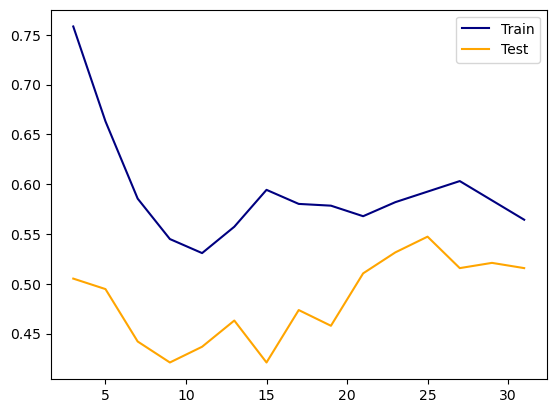

In [1314]:
df_score = pd.DataFrame(scores, columns=['k', 'acc_train', 'acc_test'])
plt.plot(df_score.k, df_score.acc_train, c='navy', label='Train')
plt.plot(df_score.k, df_score.acc_test, c='orange', label='Test')
plt.legend();
plt.savefig('Knn.jpg')

Model 1, which takes the best versions of the individual variables and puts them together for analysis, barely outperforms the baseline. We will need to minimize the number of features and regularize some more.

### Model 2: Converting categorical features to text for NLP

In order to minimize features, I will combine some of the categorical features into a text cell and conduct NLP on a single concatenated string of:
- Tasks
- Tools
- Titles
- Industries

In [1315]:
industries_nlp.fillna("0", inplace=True)

In [1316]:
full_model__nlp = pd.merge(left=pd.DataFrame(full_text_for_model, columns = ["task_title"]), right=industries_nlp, left_index=True, right_index=True, how="left")

In [1317]:
tools_lemmed_.reset_index(inplace=True)

In [1318]:
full_model_nlp = pd.merge(left=full_model__nlp, right=tools_lemmed_[["Tool", "Title"]], left_index=True, right_index=True, how='left')

In [1319]:
full_model_nlp["combinedtext"] = full_model_nlp[["task_title", "Tool", "Industries_adjusted"]].apply("|".join, axis=1)

In [1320]:
full_model_nlp_ = pd.merge(left=full_model_nlp, right = skills_merge, left_on='Title', right_on = 'Title', how="left")
#combine skills and tools

In [1326]:
features_to_drop_full = ['task_title', 'O*NET-SOC Code','Code', 'Industries_adjusted', 'Tool',
                         "Title", "rank_new"]

In [1327]:
Xfull_model_nlp = full_model_nlp_.drop(columns = features_to_drop_full)

In [1329]:
yfull_model_nlp = full_model_nlp_["rank_new"]

In [1330]:
Xfull_model_nlp.to_pickle("./Xfull.pkl")
yfull_model_nlp.to_pickle("./yfull.pkl")

In [1331]:
Xfull = pd.read_pickle(r'../pickles/Xfull.pkl')
yfull = pd.read_pickle(r'../pickles/yfull.pkl')

#### Clusters on our full dataset

In [1332]:
cvec = CountVectorizer(stop_words=stops)
combined_text_lemmed = cvec.fit_transform(Xfull["combinedtext"])
fulltext_lemmed = pd.DataFrame(combined_text_lemmed.todense(), columns=cvec.get_feature_names_out())

In [1335]:
Xfull_lemmed = pd.merge(left = Xfull.drop(columns = ["combinedtext"]), 
                        right = fulltext_lemmed, left_index=True, right_index=True, how="left")

In [1337]:
ss = StandardScaler()
Xfull_scaled = ss.fit_transform(Xfull_lemmed)

In [1338]:
score = []

for k in range(50,70):
    cl = KMeans(n_clusters=k, random_state=42, n_init=10)
    cl.fit(Xfull_scaled)

    sil = silhouette_score(Xfull_scaled, cl.labels_)


    score.append([k, cl.inertia_, sil])

score_df = pd.DataFrame(score, columns=['k', 'inertia', 'silhouette'])
score_df

,k,inertia,silhouette
0,50,1.176562e+07,-0.174456
1,51,1.174347e+07,-0.205821
2,52,1.165191e+07,-0.092054
3,53,1.169294e+07,-0.117551
4,54,1.158861e+07,-0.143153
5,55,1.150923e+07,-0.203699
6,56,1.155300e+07,-0.145716
7,57,1.141201e+07,-0.205646
8,58,1.135223e+07,-0.170334
9,59,1.134161e+07,-0.204492


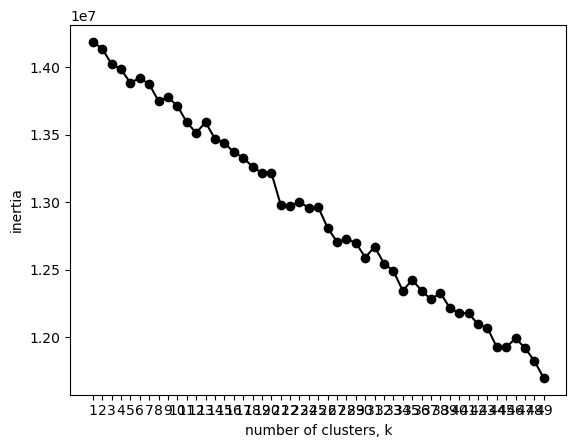

<Figure size 640x480 with 0 Axes>

In [1339]:
ks = range(1, 50)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(Xfull_scaled)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('../Images/Km_full.jpg');

In [1340]:
km_full = KMeans(random_state=16, n_init=10, n_clusters=30)
km_full.fit(Xfull_scaled)

KMeans(n_clusters=30, n_init=10, random_state=16)

In [1341]:
centroids = pd.DataFrame(
km_full.cluster_centers_, columns = Xfull_lemmed.columns)

In [1342]:
pca_2 = PCA(2)
pca_2_full = pd.DataFrame(pca_2.fit_transform(Xfull_scaled),columns=['PC1','PC2'])

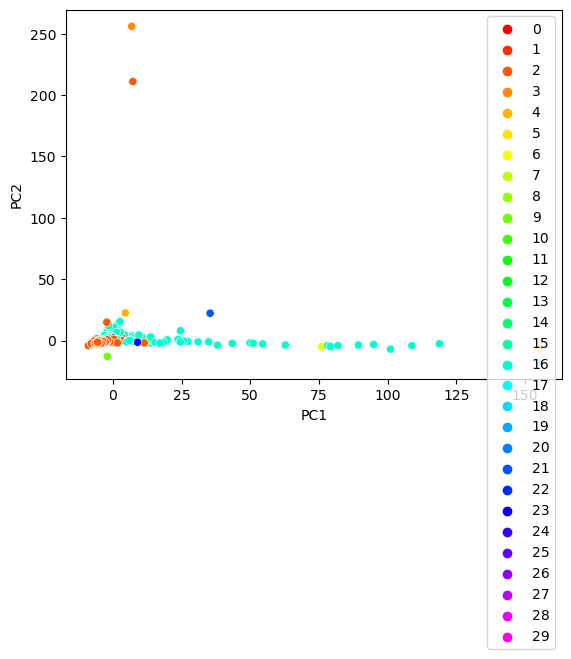

In [1343]:
pca_2_full['cluster'] = pd.Categorical(km_full.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_full, palette="gist_rainbow")

plt.legend(loc='upper right')
plt.savefig('../Images/fulldata clusters.jpg');

In [1344]:
X_fullnlp_train, X_fullnlp_test, y_train, y_test = train_test_split(Xfull_model_nlp,
                                                    yfull_model_nlp,
                                                    random_state=42, stratify=yfull_model_nlp)

In [1345]:
column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1346]:
pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [1347]:
pipe_full_logr.fit(X_fullnlp_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x283d6ffd0>),
                                                 ('combined', CountVectorizer(),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr', LogisticRegression(solver='liblinear'))])

In [1348]:
pipe_full_logr_preds = pipe_full_logr.predict(X_fullnlp_test)

In [1349]:
logistic_full = evaluation("Logistical Regression - Full", y_test, pipe_full_logr_preds, pipe_full_logr,
                                X_fullnlp_train, X_fullnlp_test)

In [1350]:
logistic_full

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,1.0,0.516,0.581,0.651,0.545,0.562


While the model is still overfitting - this is expected given the small sample size relative to feature set. There is some improvement when combining all the features (except skills) into a single text column. I'll move forward with regularization to see if the model can do even better.

In [1351]:
pipe_params_cvec_full = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.01, 1.0, 10, 100],
    'logr__penalty': ['l2'],
    'logr__max_iter': [1000]
}

In [1352]:
gs_full_cvec_logr = GridSearchCV(pipe_full_logr,
                pipe_params_cvec_full,
                  cv = 5)

In [1353]:
gs_full_cvec_logr.fit(X_fullnlp_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x283d6ffd0>),
                                                                        ('combined',
                                                                         CountVectorizer(),
                                                                         'combinedtext')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C': [...
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [1354]:
gs_full_cvec_logr_preds = gs_full_cvec_logr.predict(X_fullnlp_test)

In [1355]:
logistic_full_regularized = evaluation("Logistical Regression - Full (NLP)", y_test, gs_full_cvec_logr_preds, gs_full_cvec_logr,
                                X_fullnlp_train, X_fullnlp_test)

In [1356]:
logistic_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full (NLP),0.956,0.537,0.587,0.682,0.569,0.578


The model continues to overfit, and will need more data to train on. In the meantime, I will try TFIDF, Multinomial and KNN to see if there's any additional improvements that can be made on the data set.

In [1357]:
pipe_params_cvec_full_ = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.001, 0.1, 1.0, 10],
    'logr__penalty': ['l2','l1'],
    'logr__max_iter': [3000]
}

In [1358]:
pipe_full_logr_ = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [1359]:
gs_full_cvec_logr_ = GridSearchCV(pipe_full_logr_,
                pipe_params_cvec_full_,
                  cv = 5)

In [1360]:
gs_full_cvec_logr_.fit(X_fullnlp_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x283d6ffd0>),
                                                                        ('combined',
                                                                         CountVectorizer(),
                                                                         'combinedtext')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C': [...
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [1361]:
gs_full__cvec_logr_preds = gs_full_cvec_logr_.predict(X_fullnlp_test)

In [1362]:
logistic_full__regularized = evaluation("Logistical Regression - Full", y_test, gs_full__cvec_logr_preds, gs_full_cvec_logr_,
                                X_fullnlp_train, X_fullnlp_test)

In [1372]:
logistic_full__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.707,0.532,0.485,0.717,0.552,0.516


There's much less overfitting; however, the model continues to perform poorly. A larger sample size would be needed in order to better train the model.

In [1373]:
column_trans_tvec = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', TfidfVectorizer(), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1374]:
pipe_params_tvec_full_ = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.001, 0.1, 1.0, 10],
    'logr__penalty': ['l2','l1'],
    'logr__max_iter': [3000]
}

In [1375]:
pipe_full_logr_ = Pipeline(
    steps = [
    ('preprocess', column_trans_tvec),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [1376]:
gs_full_tvec_logr_ = GridSearchCV(pipe_full_logr_,
                pipe_params_tvec_full_,
                  cv = 5)

In [1377]:
gs_full_tvec_logr_.fit(X_fullnlp_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x2d1fbff10>),
                                                                        ('combined',
                                                                         TfidfVectorizer(),
                                                                         'combinedtext')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C': [...
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [1368]:
gs_full__tvec_logr_preds = gs_full_cvec_logr_.predict(X_fullnlp_test)

In [1369]:
logistic_full_tvec__regularized = evaluation("Logistical Regression - Full (TVEC)", y_test, gs_full__tvec_logr_preds, gs_full_tvec_logr_,
                                X_fullnlp_train, X_fullnlp_test)

In [1370]:
logistic_full_tvec__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full (TVEC),0.64,0.5,0.485,0.717,0.552,0.516


There's less overfitting, but the model performs slightly worse than the CVEC model. We will stay with CVEC and regularization pipeline, and continue with the best model.

In [1385]:
best_column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(max_features= 5000, min_df = 2, max_df = 0.9, ngram_range = (1,2), stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1386]:
best_pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', best_column_trans),
    ('logr', LogisticRegression(solver="liblinear", C = 0.001, max_iter=3000, penalty = "l2", random_state=16))
])

In [1387]:
best_pipe_full_logr.fit(X_fullnlp_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2c6d6da50>),
                                                 ('combined',
                                                  CountVectorizer(max_df=0.9,
                                                                  max_features=5000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr',
                 LogisticRegression(C=0.001, max_iter=3000, random_state=16,
                                    solver='liblinear'))])

In [1388]:
best_pipe_full_logr_preds = best_pipe_full_logr.predict(X_fullnlp_test)

In [1389]:
joblib.dump(best_pipe_full_logr, 'Model.pkl')

['Model.pkl']

In [1390]:
logistic_full__regularized = evaluation("Logistical Regression (CVEC) - Full", y_test, best_pipe_full_logr_preds , best_pipe_full_logr,
                                X_fullnlp_train, X_fullnlp_test)

In [1391]:
logistic_full__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression (CVEC) - Full,0.707,0.532,0.485,0.717,0.552,0.516


### Multinomial

In [1392]:
column_trans_mnb = ColumnTransformer(
  [('scaled', MinMaxScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1393]:
pipe_full_mnb = Pipeline(
    steps = [
    ('preprocess', column_trans_mnb),
    ('mnb', MultinomialNB(alpha=0.01))
])

In [1394]:
pipe_full_mnb.fit(X_fullnlp_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2d207be10>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('mnb', MultinomialNB(alpha=0.01))])

In [1395]:
gs_full_cvec_mnb_preds = pipe_full_mnb.predict(X_fullnlp_test)

In [1396]:
multinomial_full_regularized = evaluation("Logistical Regression - Full", y_test, gs_full_cvec_mnb_preds, pipe_full_mnb,
                                X_fullnlp_train, X_fullnlp_test)

In [1397]:
multinomial_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.981,0.505,0.582,0.682,0.542,0.561


### KNN

In [1398]:
column_trans_knn = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [1399]:
pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier())
])

In [1400]:
pipe_full_knn.fit(X_fullnlp_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x29d260cd0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

In [1401]:
pipe_full_knn.score(X_fullnlp_test, y_test)

0.5263157894736842

In [1402]:
scores = []

for k in range(3, 32, 2):
    pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier(n_neighbors=k))
])
    pipe_full_knn.fit(X_fullnlp_train, y_train)
    acc_train = pipe_full_knn.score(X_fullnlp_train, y_train)
    acc_test = pipe_full_knn.score(X_fullnlp_test, y_test)
    scores.append((k, acc_train, acc_test))

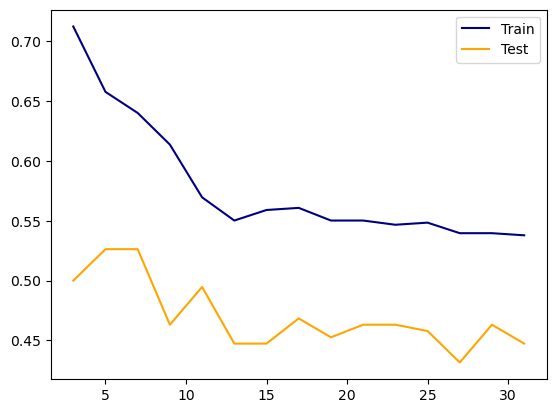

In [1403]:
df_score = pd.DataFrame(scores, columns=['k', 'acc_train', 'acc_test'])
plt.plot(df_score.k, df_score.acc_train, c='navy', label='Train')
plt.plot(df_score.k, df_score.acc_test, c='orange', label='Test')
plt.legend();
plt.savefig('Knn.jpg')

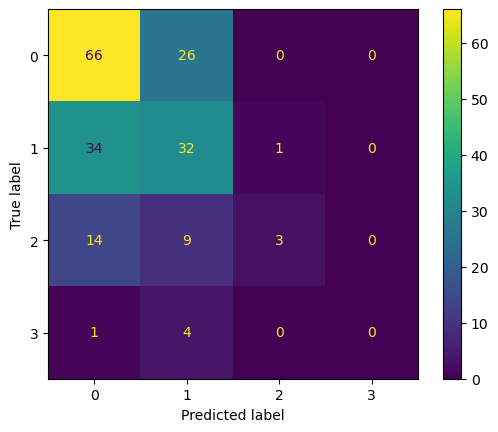

In [1404]:
cm = confusion_matrix(y_test,best_pipe_full_logr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();